# Leios simulation analysis for CIP

## Set up

### Load packages

In [1]:
suppressMessages({
    require(RColorBrewer, quietly=TRUE)
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
})

## Experiment: Varying throughput and transaction validation

In [2]:
simVersion <- readLines("sim-cli.hash")

### Analysis of lifecycles and efficiencies

#### Read the lifecycle results

In [3]:
if (file.exists("results/lifecycle.Rdata")) {
    load(file="results/lifecycle.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    lifecycle <- fread("results/lifecycle.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
    save(lifecycle, sampleSize, file="results/lifecycle.R")
    cat(paste("Saved Rdata file: sampleSize =", sampleSize, "\n"))
}
setnames(lifecycle, old="Kind", new="Message")
lifecycle <- lifecycle[`Throughput` != "0.300 TxMB/s"]
lifecycle %>% summary

Loaded Rdata file: sampleSize = 1 


        Network          Bandwidth                CPU         
 topology-v2:1405429   10 Mb/s:1405429   4 vCPU/node:1405429  
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
        Diffusion duration          Voting duration      Max EB size     
 L_diff = 7 slots:1405429   L_vote = 4 slots:1405429   12 MB/EB:1405429  
                                                                         
                                                                         
                                                                         
                                                                         
                                                    

In [4]:
label <- lifecycle[, unique(paste(simVersion, `Network`, `Bandwidth`, `CPU`, `Diffusion duration`, `Voting duration`, `Max EB size`, `Tx size`, sep=", "))]
label

[1] "sim-cli 1.3.1-0156b0451, topology-v2, 10 Mb/s, 4 vCPU/node, L_diff = 7 slots, L_vote = 4 slots, 12 MB/EB, 1500 B/Tx"

In [5]:
fixed <- c("Network", "Bandwidth", "CPU", "Diffusion duration", "Voting duration", "Max EB size", "Tx size")

In [6]:
variedX <- c("Throughput")

In [7]:
variedY <- c("Plutus")

In [8]:
varied <- c(variedX, variedY)

In [9]:
lifecycle[, `:=`(
    `VariedX`=`Throughput`,
    `VariedY`=factor(`Plutus`, levels=c("", "1000 Gstep/EB", "2000 Gstep/EB", "5000 Gstep/EB", "10000 Gstep/EB", "20000 Gstep/EB", "50000 Gstep/EB"))
)]

In [10]:
facet_varied_x <- function(scales="fixed", wide=FALSE) {
    if (wide)
        facet_grid(`VariedX` ~ ., scales=scales)
    else
        facet_grid(. ~ `VariedX`, scales=scales)
}

In [11]:
facet_varied <- function(scales="fixed", wide=FALSE) {
    if (wide)
        facet_grid(`VariedX` ~ `VariedY`, scales=scales)
    else
        facet_grid(`VariedY` ~ `VariedX`, scales=scales)
}

In [12]:
yConstraint <- ""

#### Range of transaction injection

In [13]:
txFirst <- lifecycle[, median(`Tx start [s]`)]
txLast <- lifecycle[, median(`Tx stop [s]`)]
txWindow <- txLast - txFirst
simFinish <- lifecycle[, median(`Sim stop [s]`)]

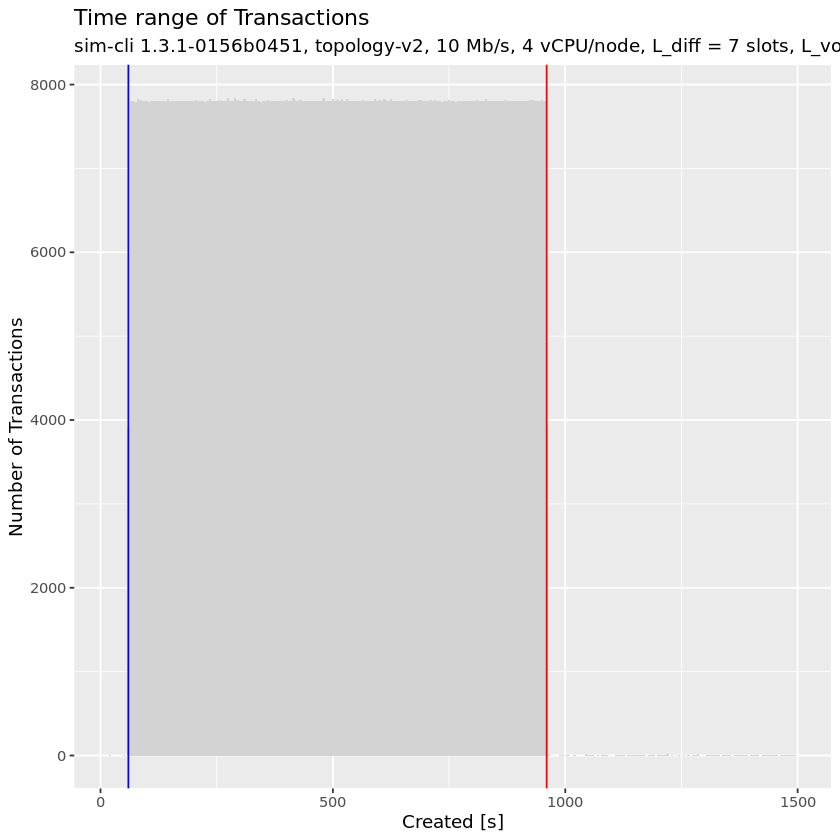

In [14]:
ggplot(lifecycle, aes(x=`Created [s]`)) +
    geom_histogram(binwidth=5, fill="lightgray") +
    geom_vline(xintercept=txFirst, color="blue") +
    geom_vline(xintercept=txLast, color="red") +
    ylab("Number of Transactions") +
    ggtitle("Time range of Transactions", label)

#### Actual TPS

In [15]:
dtmp <- lifecycle[
    `Message` == "TX" & `Created [s]` >= txFirst & `Created [s]` <= txLast, 
    .(
        `Demand [tx/s]`=.N/txWindow
    ),
    c(fixed, varied)
]
setorderv(dtmp, varied)
dtmp

Network,Bandwidth,CPU,Diffusion duration,Voting duration,Max EB size,Tx size,Throughput,Plutus,Demand [tx/s]
<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>
topology-v2,10 Mb/s,4 vCPU/node,L_diff = 7 slots,L_vote = 4 slots,12 MB/EB,1500 B/Tx,0.001 TxMB/s,,0.6666667
topology-v2,10 Mb/s,4 vCPU/node,L_diff = 7 slots,L_vote = 4 slots,12 MB/EB,1500 B/Tx,0.100 TxMB/s,,66.6666667
topology-v2,10 Mb/s,4 vCPU/node,L_diff = 7 slots,L_vote = 4 slots,12 MB/EB,1500 B/Tx,0.150 TxMB/s,,100.0011111
topology-v2,10 Mb/s,4 vCPU/node,L_diff = 7 slots,L_vote = 4 slots,12 MB/EB,1500 B/Tx,0.200 TxMB/s,,142.8577778
topology-v2,10 Mb/s,4 vCPU/node,L_diff = 7 slots,L_vote = 4 slots,12 MB/EB,1500 B/Tx,0.250 TxMB/s,,166.6677778
topology-v2,10 Mb/s,4 vCPU/node,L_diff = 7 slots,L_vote = 4 slots,12 MB/EB,1500 B/Tx,0.250 TxMB/s,1000 Gstep/EB,166.6666667
topology-v2,10 Mb/s,4 vCPU/node,L_diff = 7 slots,L_vote = 4 slots,12 MB/EB,1500 B/Tx,0.250 TxMB/s,10000 Gstep/EB,166.6666667
topology-v2,10 Mb/s,4 vCPU/node,L_diff = 7 slots,L_vote = 4 slots,12 MB/EB,1500 B/Tx,0.250 TxMB/s,2000 Gstep/EB,166.6677778
topology-v2,10 Mb/s,4 vCPU/node,L_diff = 7 slots,L_vote = 4 slots,12 MB/EB,1500 B/Tx,0.250 TxMB/s,20000 Gstep/EB,166.6677778


#### Size of persisted data

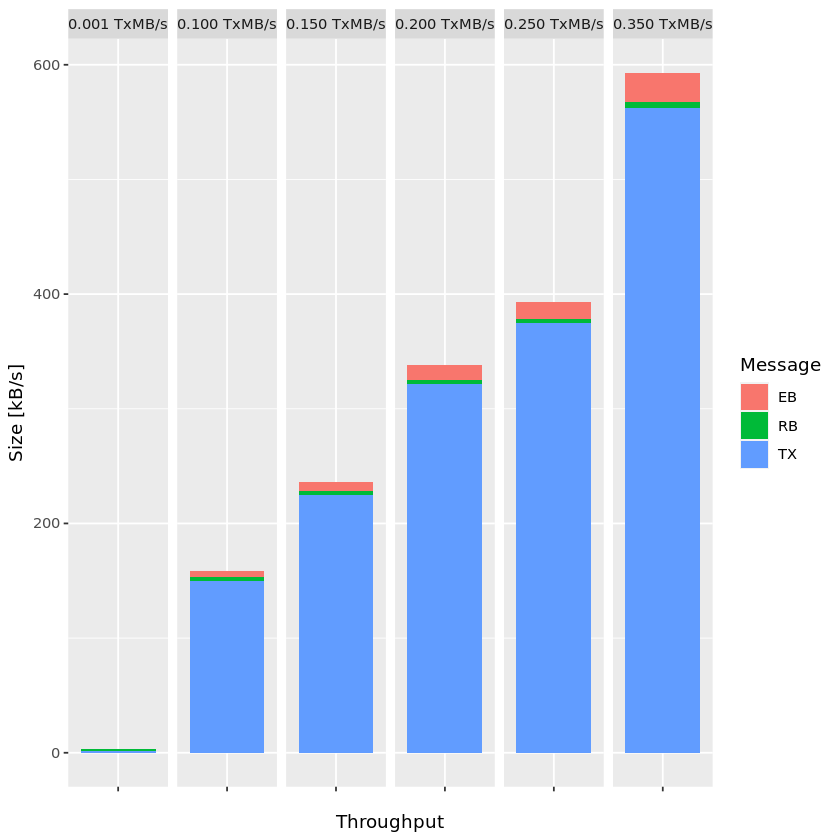

In [16]:
ggplot(
    lifecycle[
        `VariedY` == yConstraint,
        .(`Size [kB/s]`=sum(`Size [B]`)/1e3/600),
        c("VariedX", "VariedY", "Message")
    ],
    aes(x="", y=`Size [kB/s]`, fill=`Message`)
) + geom_bar(stat="identity") +
    facet_varied_x(scales="fixed") +
    xlab(variedX)

#### Spatial efficiency

In [17]:
dtmp <- lifecycle[
        , 
        .(`Tx size [B]`=sum(ifelse(is.na(`To RB [s]`) & is.na(`In RB [s]`), 0, 1.0 * `Size [B]`))),
        varied
    ][
        lifecycle[
            , 
            .(`Non-tx size [B]`=sum(as.numeric((`Message` == "TX" | `Message` == "EB" | `Message` == "RB") * `Size [B]`))), 
            varied
        ],
        on=varied
    ][, .(`Space efficiency [%]`=100*`Tx size [B]`/`Non-tx size [B]`), varied]
setorderv(dtmp, varied)
dtmp

Throughput,Plutus,Space efficiency [%]
<fct>,<fct>,<dbl>
0.001 TxMB/s,,47.82696
0.100 TxMB/s,,96.57303
0.150 TxMB/s,,97.22748
0.200 TxMB/s,,97.17854
0.250 TxMB/s,,97.49422
0.250 TxMB/s,1000 Gstep/EB,97.74408
0.250 TxMB/s,10000 Gstep/EB,97.30343
0.250 TxMB/s,2000 Gstep/EB,97.49329
0.250 TxMB/s,20000 Gstep/EB,95.95141


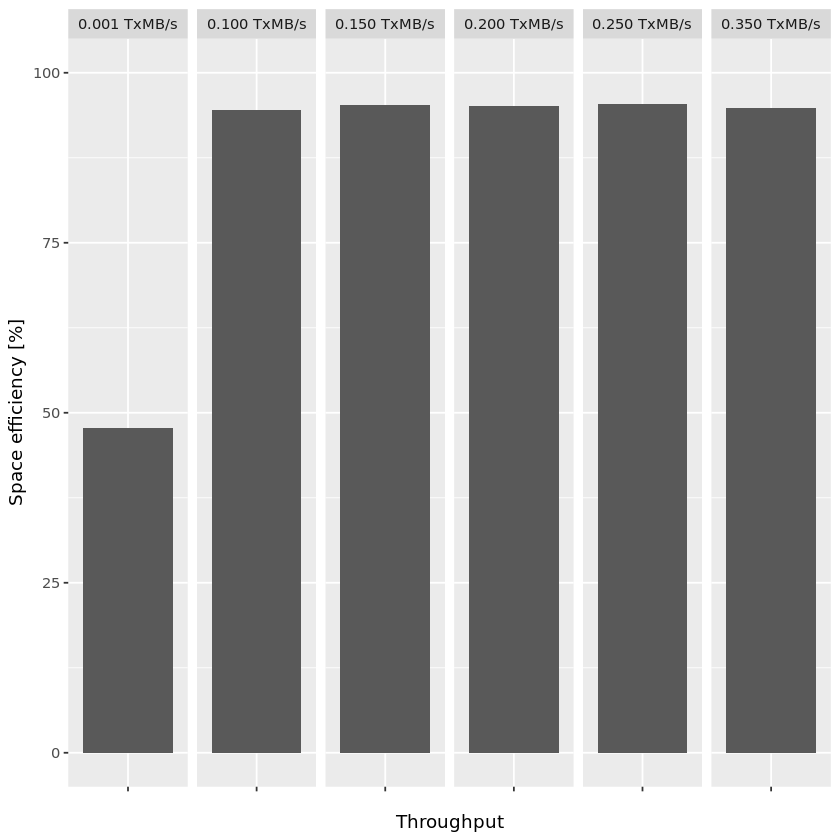

In [18]:
ggplot(
    lifecycle[
        `VariedY` == yConstraint & `Message` == "TX", 
        .(`Tx size [B]`=sum(ifelse(is.na(`To RB [s]`) & is.na(`In RB [s]`), 0, 1.0 * `Size [B]`))),
        .(`VariedX`, `VariedY`)
    ][
        lifecycle[
            `VariedY` == yConstraint & `Message` != "VT", 
            .(`Non-tx size [B]`=sum(as.numeric((`Message` == "TX" | `Message` == "EB" | `Message` == "RB") * `Size [B]`))), 
            .(`VariedX`, `VariedY`)
        ],
        on=c("VariedX", "VariedY")
    ][, .(`Space efficiency [%]`=100*`Tx size [B]`/`Non-tx size [B]`), .(`VariedX`, `VariedY`)],
    aes(x="", y=`Space efficiency [%]`)
) +
    geom_bar(stat="identity") +
    facet_varied_x(scales="fixed") +
    ylim(0, 100) +
    xlab(variedX)

#### Time to reach the EB

In [19]:
dtmp <- lifecycle[
        `Message` == "TX" & 
        !is.na(`To EB [s]`) &
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach EB [s]`=mean(`To EB [s]`-`Created [s]`)), 
        varied
    ]
setorderv(dtmp, varied)
dtmp

Throughput,Plutus,Time to reach EB [s]
<fct>,<fct>,<dbl>
0.100 TxMB/s,,17.84663
0.150 TxMB/s,,17.87802
0.200 TxMB/s,,22.63319
0.250 TxMB/s,,22.93512
0.250 TxMB/s,1000 Gstep/EB,19.89204
0.250 TxMB/s,10000 Gstep/EB,30.76769
0.250 TxMB/s,2000 Gstep/EB,22.96143
0.250 TxMB/s,20000 Gstep/EB,51.43745
0.250 TxMB/s,5000 Gstep/EB,30.66175


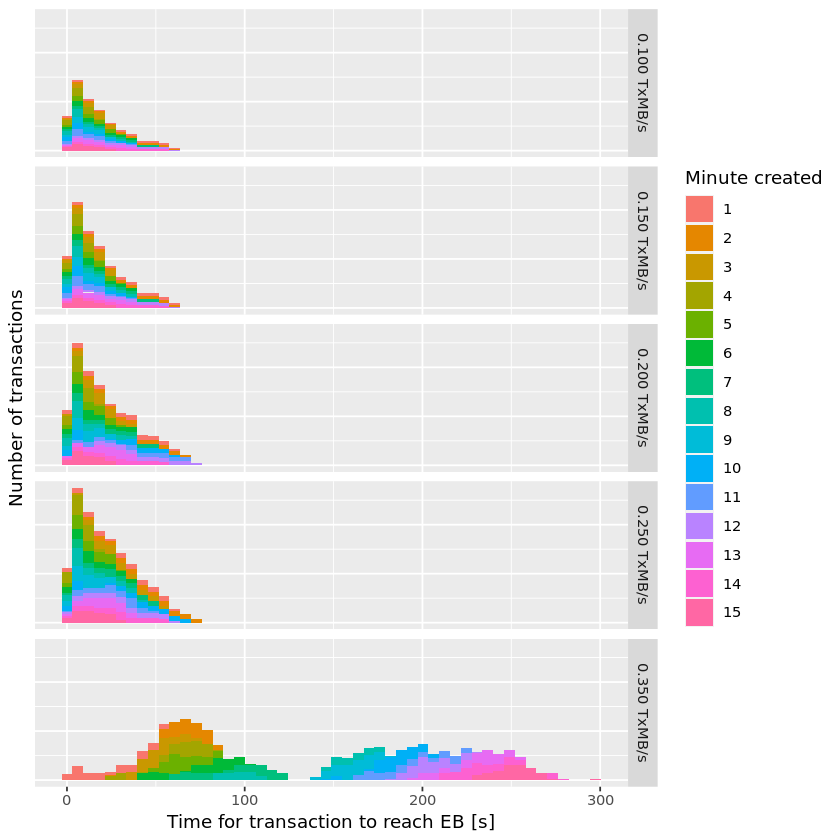

In [20]:
ggplot(
        lifecycle[
            `VariedY` == yConstraint & `Message` == "TX" & 
            !is.na(`To EB [s]`) &
            `Created [s]` >= txFirst & `Created [s]` < txLast, 
            .(`Time to reach EB [s]`=(`To EB [s]`-`Created [s]`)), 
            .(`VariedX`, `VariedY`, `Minute created`=factor(floor(`Created [s]`/60)))
        ],
    aes(x=`Time to reach EB [s]`, fill=`Minute created`)
) + geom_histogram(bins=50, position="stack") +
    facet_varied_x(wide=TRUE) +
    xlab("Time for transaction to reach EB [s]") +
    ylab("Number of transactions") +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

#### Time to reach the ledger

In [21]:
dtmp <- lifecycle[
        `Message` == "TX" & 
        !is.na(`To RB [s]`) &
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach ledger [s]`=mean(`To RB [s]`-`Created [s]`)), 
        varied
    ]
setorderv(dtmp, varied)
dtmp

Throughput,Plutus,Time to reach ledger [s]
<fct>,<fct>,<dbl>
0.100 TxMB/s,,54.72993
0.150 TxMB/s,,54.90817
0.200 TxMB/s,,64.46736
0.250 TxMB/s,,62.00459
0.250 TxMB/s,1000 Gstep/EB,57.19275
0.250 TxMB/s,10000 Gstep/EB,72.55044
0.250 TxMB/s,2000 Gstep/EB,62.03510
0.250 TxMB/s,20000 Gstep/EB,99.67690
0.250 TxMB/s,5000 Gstep/EB,72.44475


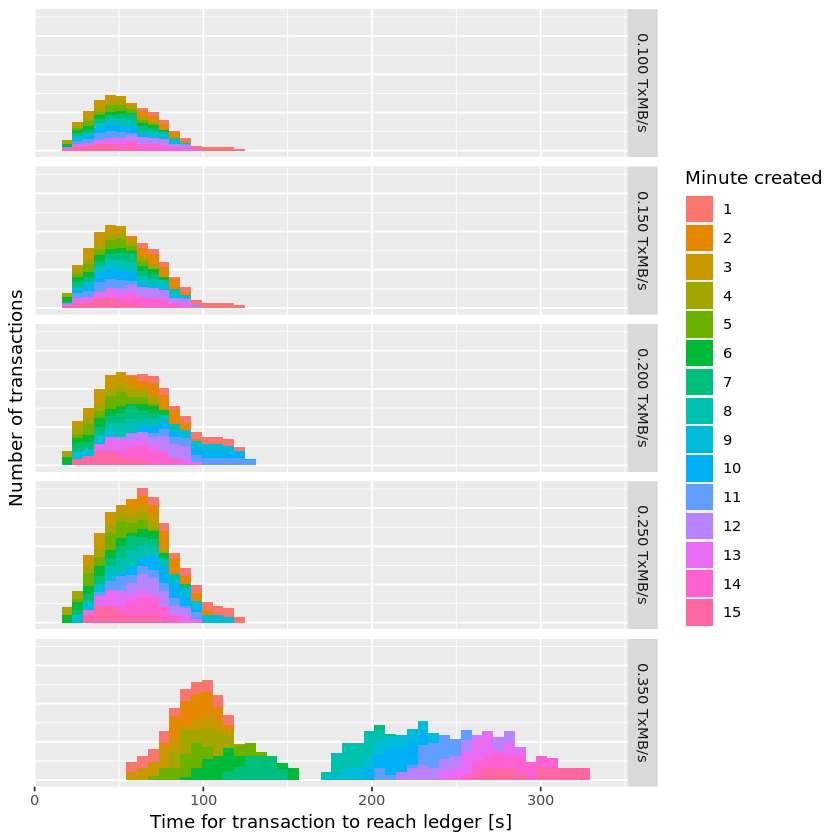

In [22]:
ggplot(
        lifecycle[
            `VariedY` == yConstraint & `Message` == "TX" & 
            !is.na(`To RB [s]`) &
            `Created [s]` >= txFirst & `Created [s]` < txLast, 
            .(`Time to reach ledger [s]`=`To RB [s]`-`Created [s]`), 
            .(`VariedX`, `VariedY`, `Minute created`=factor(floor(`Created [s]`/60)))
        ],
    aes(x=`Time to reach ledger [s]`, fill=`Minute created`)
) + geom_histogram(bins=50) +
    facet_varied_x(wide=TRUE) +
    xlab("Time for transaction to reach ledger [s]") +
    ylab("Number of transactions") +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [23]:
ggsave("plots/reach-rb-tx.svg", units="in", dpi=150, width=16, height=8)

In [24]:
ggsave("plots/reach-rb-tx.png", units="in", dpi=150, width=16, height=8)

#### Number of references

A *reference* is one of the following:

- A transaction is included in an IB.
- An IB is referenced by an EB.
- An EB is referenced by another EB.

In an efficient Leios, the number of references for each data item would be one.

- *Zero references* indicates that the item was not used.
- *Two or more references* indicates that duplication has occurred.

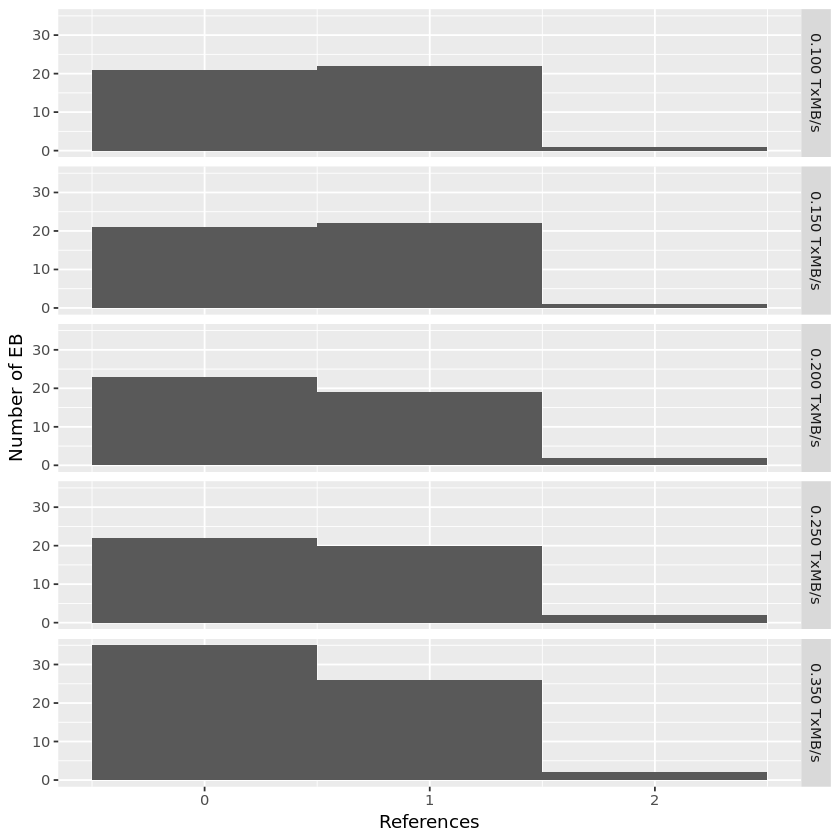

In [25]:
ggplot(
    lifecycle[
        `VariedY` == yConstraint & `Message` == "EB",
        .(`References`),
        .(`VariedX`, `VariedY`)
    ], 
    aes(x=`References`)
) +
    geom_histogram(binwidth=1) +
    facet_varied_x(wide=TRUE) +
    ylab("Number of EB")

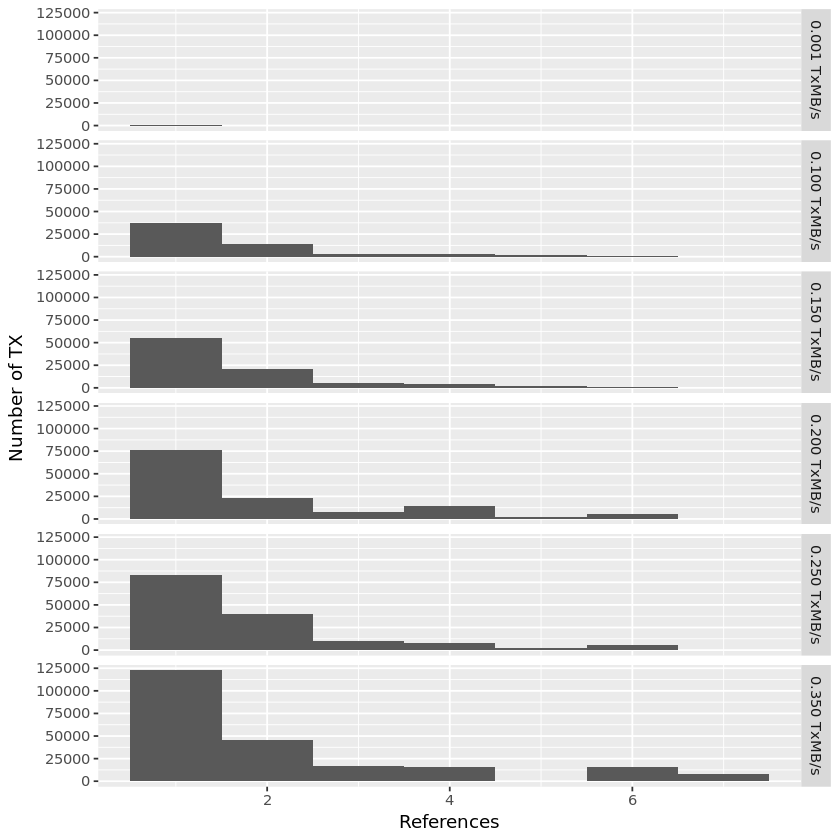

In [26]:
ggplot(
    lifecycle[
        `VariedY` == yConstraint & `Message` == "TX",
        .(`References`),
        .(`VariedX`, `VariedY`)
    ], 
    aes(x=`References`)
) +
    geom_histogram(binwidth=1) +
    facet_varied_x(wide=TRUE) +
    ylab("Number of TX")

In [27]:
ggsave("plots/references-tx.svg", units="in", dpi=150, width=16, height=8)

In [28]:
ggsave("plots/references-tx.png", units="in", dpi=150, width=16, height=8)

#### Temporal efficiency

In [29]:
toElapsed <- function(created, toRb, inRb) {
    if (!is.na(toRb))
        toRb - created
    else if (!is.na(inRb))
        inRb - created
    else
        as.numeric(NA)
}

In [30]:
outcomes <- lifecycle[
    `Message` == "TX" & `Created [s]` < txLast,
    .(
        `Submitted [minute]`=factor(floor(`Created [s]`/60)), 
        `Time to reach ledger [s]`=mapply(toElapsed, `Created [s]`, `To RB [s]`, `In RB [s]`)
    ),
    .(`VariedX`, `VariedY`)
]

In [31]:
totals <- 
    outcomes[
        , 
        .(
            `Total`=.N, 
            `Lost`=sum(is.na(`Time to reach ledger [s]`)),
            `1st min`=sum(`Time to reach ledger [s]`<=60,na.rm=TRUE),
            `2nd min`=sum(`Time to reach ledger [s]`>60&`Time to reach ledger [s]`<=120,na.rm=TRUE),
            `3rd min`=sum(`Time to reach ledger [s]`>120&`Time to reach ledger [s]`<=180,na.rm=TRUE)
        ), 
        .(`VariedX`, `VariedY`, `Submitted [minute]`)
    ]

#### Transactions reaching the ledger

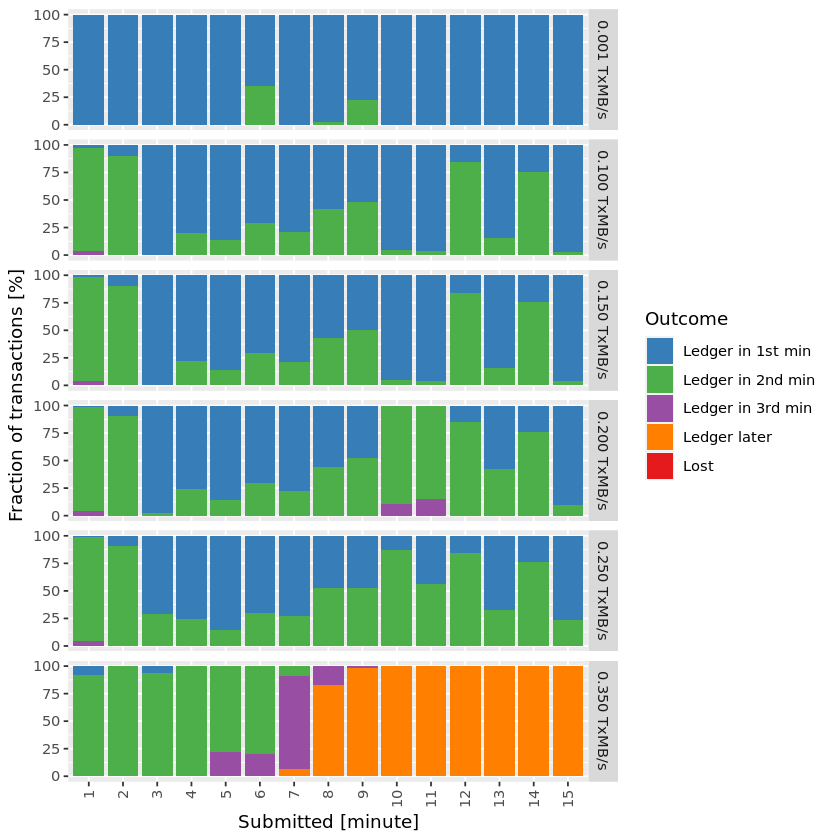

In [32]:
ggplot(
        melt(
            totals[
                `VariedY` == yConstraint, 
                .(
                    `Ledger in 1st min`=`1st min`/`Total`, 
                    `Ledger in 2nd min`=`2nd min`/`Total`, 
                    `Ledger in 3rd min`=`3rd min`/`Total`, 
                    `Ledger later`=(`Total`-`Lost`-`1st min`-`2nd min`-`3rd min`)/`Total`,
                    `Lost`=`Lost`/`Total`
                ), 
                .(`VariedX`, `VariedY`, `Submitted [minute]`)
            ],
            id.vars=c("VariedX", "VariedY", "Submitted [minute]"),
            variable.name="Outcome",
            value.name="Fraction"
        )[, .(
            `VariedX`, `VariedY`,
            `Submitted [minute]`, 
            `Outcome`=factor(`Outcome`,levels=c("Ledger in 1st min", "Ledger in 2nd min", "Ledger in 3rd min", "Ledger later","Lost")), 
            `Fraction of transactions [%]`=100*`Fraction`
        )],
    aes(x=`Submitted [minute]`, y=`Fraction of transactions [%]`, fill=`Outcome`)
) +
    geom_bar(stat="identity") +
    facet_varied_x(wide=TRUE) +
    scale_fill_manual(values=c(
        "Ledger in 1st min"=brewer.pal(n=5, name="Set1")[[2]], 
        "Ledger in 2nd min"=brewer.pal(n=5, name="Set1")[[3]], 
        "Ledger in 3rd min"=brewer.pal(n=5, name="Set1")[[4]], 
        "Ledger later"=brewer.pal(n=5, name="Set1")[[5]],
        "Lost"=brewer.pal(n=5, name="Set1")[[1]]
    )) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [33]:
ggsave("plots/temporal-efficiency-bar.svg", units="in", dpi=150, width=16, height=8)

In [34]:
ggsave("plots/temporal-efficiency-bar.png", units="in", dpi=150, width=16, height=8)

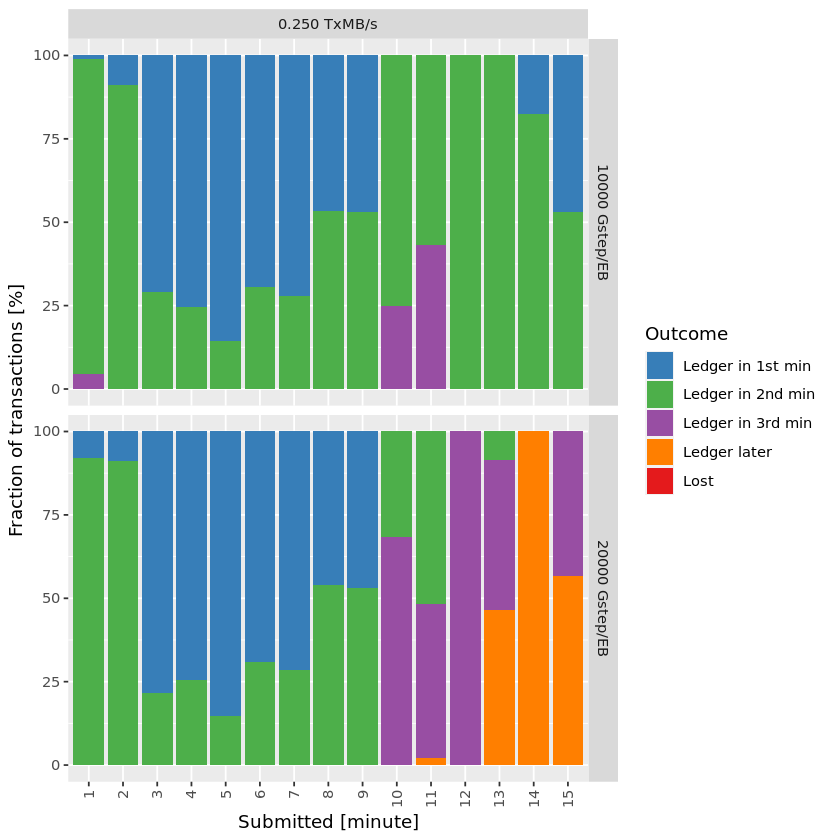

In [35]:
ggplot(
        melt(
            totals[
               `VariedY` %in% c("10000 Gstep/EB", "20000 Gstep/EB", "50000 Gstep/EB"), 
                .(
                    `Ledger in 1st min`=`1st min`/`Total`, 
                    `Ledger in 2nd min`=`2nd min`/`Total`, 
                    `Ledger in 3rd min`=`3rd min`/`Total`, 
                    `Ledger later`=(`Total`-`Lost`-`1st min`-`2nd min`-`3rd min`)/`Total`,
                    `Lost`=`Lost`/`Total`
                ), 
                .(`VariedX`, `VariedY`, `Submitted [minute]`)
            ],
            id.vars=c("VariedX", "VariedY", "Submitted [minute]"),
            variable.name="Outcome",
            value.name="Fraction"
        )[, .(
            `VariedX`, `VariedY`,
            `Submitted [minute]`, 
            `Outcome`=factor(`Outcome`,levels=c("Ledger in 1st min", "Ledger in 2nd min", "Ledger in 3rd min", "Ledger later","Lost")), 
            `Fraction of transactions [%]`=100*`Fraction`
        )],
    aes(x=`Submitted [minute]`, y=`Fraction of transactions [%]`, fill=`Outcome`)
) +
    geom_bar(stat="identity") +
    facet_varied(wide=FALSE) +
    scale_fill_manual(values=c(
        "Ledger in 1st min"=brewer.pal(n=5, name="Set1")[[2]], 
        "Ledger in 2nd min"=brewer.pal(n=5, name="Set1")[[3]], 
        "Ledger in 3rd min"=brewer.pal(n=5, name="Set1")[[4]], 
        "Ledger later"=brewer.pal(n=5, name="Set1")[[5]],
        "Lost"=brewer.pal(n=5, name="Set1")[[1]]
    )) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [36]:
ggsave("plots/plutus-temporal-efficiency-bar.svg", units="in", dpi=150, width=16, height=8)

In [37]:
ggsave("plots/plutus-temporal-efficiency-bar.png", units="in", dpi=150, width=16, height=8)

#### Summary for cost estimations

In [38]:
diskSummary <- lifecycle[
    `Created [s]` >= txFirst + 30 &
    `Created [s]` < txLast - 30 &
    (!is.na(`To RB [s]`) | !is.na(`In RB [s]`)),
    .(
        `Disk [MB/s/node]` = sum(`Size [B]`) / sampleSize / 1e6 / (txLast - txFirst - 2 * 30)
    ),
    .(`VariedX`, `VariedY`)
]
diskSummary

VariedX,VariedY,Disk [MB/s/node]
<fct>,<fct>,<dbl>
0.100 TxMB/s,,0.1019651
0.150 TxMB/s,,0.1529632
0.200 TxMB/s,,0.2185296
0.250 TxMB/s,,0.2549593
0.001 TxMB/s,,0.0010000
0.350 TxMB/s,,0.3807959
0.250 TxMB/s,1000 Gstep/EB,0.2549304
0.250 TxMB/s,10000 Gstep/EB,0.2548794
0.250 TxMB/s,20000 Gstep/EB,0.2545455


#### Release memory

In [39]:
rm(lifecycle, outcomes, totals)

In [40]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,991222,53.0,2446565,130.7,2446565,130.7
Vcells,1923611,14.7,40316978,307.6,50396222,384.5


### Resource usage

In [41]:
if (file.exists("results/resources.Rdata")) {
    load(file="results/resources.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    resources <- fread("results/resources.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
    save(resources, file="results/resources.Rdata")
    cat(paste("Saved Rdata file: sampleSize =", sampleSize, "\n"))
}
resources <- resources[`Throughput` != "0.300 TxMB/s"]
resources %>% summary
resources[, `:=`(
    `VariedX`=factor(`Throughput`),
    `VariedY`=factor(`Plutus`, levels=c("", "1000 Gstep/EB", "2000 Gstep/EB", "5000 Gstep/EB", "10000 Gstep/EB", "20000 Gstep/EB", "50000 Gstep/EB"))
)]

Loaded Rdata file: sampleSize = 1 


        Network       Bandwidth             CPU              Diffusion duration
 topology-v2:8250   10 Mb/s:8250   4 vCPU/node:8250   L_diff = 7 slots:8250    
                                                                               
                                                                               
                                                                               
                                                                               
                                                                               
                                                                               
         Voting duration   Max EB size        Tx size            Throughput  
 L_vote = 4 slots:8250   12 MB/EB:8250   1500 B/Tx:8250   0.001 TxMB/s: 750  
                                                          0.100 TxMB/s: 750  
                                                          0.150 TxMB/s: 750  
                                                

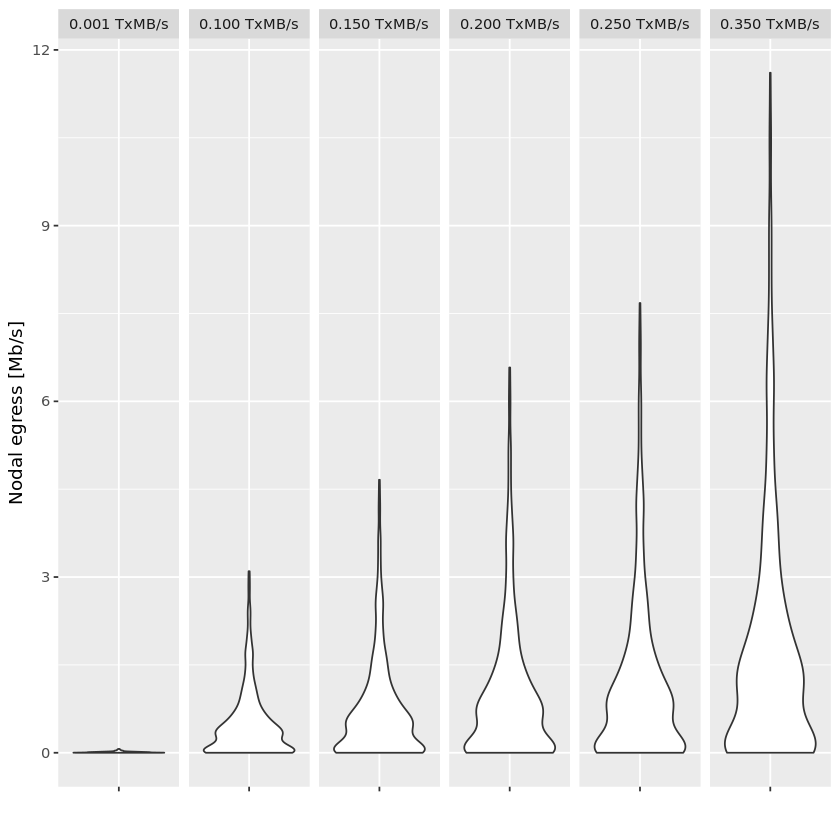

In [42]:
ggplot(
        resources[`VariedY` == yConstraint, .(`VariedX`, `VariedY`, `Node`, `Nodal egress [Mb/s]`=8*`Egress [B]`/simFinish/1e6)], 
    aes(x="", y=`Nodal egress [Mb/s]`)
) +
    geom_violin() +
    facet_varied_x(wide=FALSE) +
    xlab("")

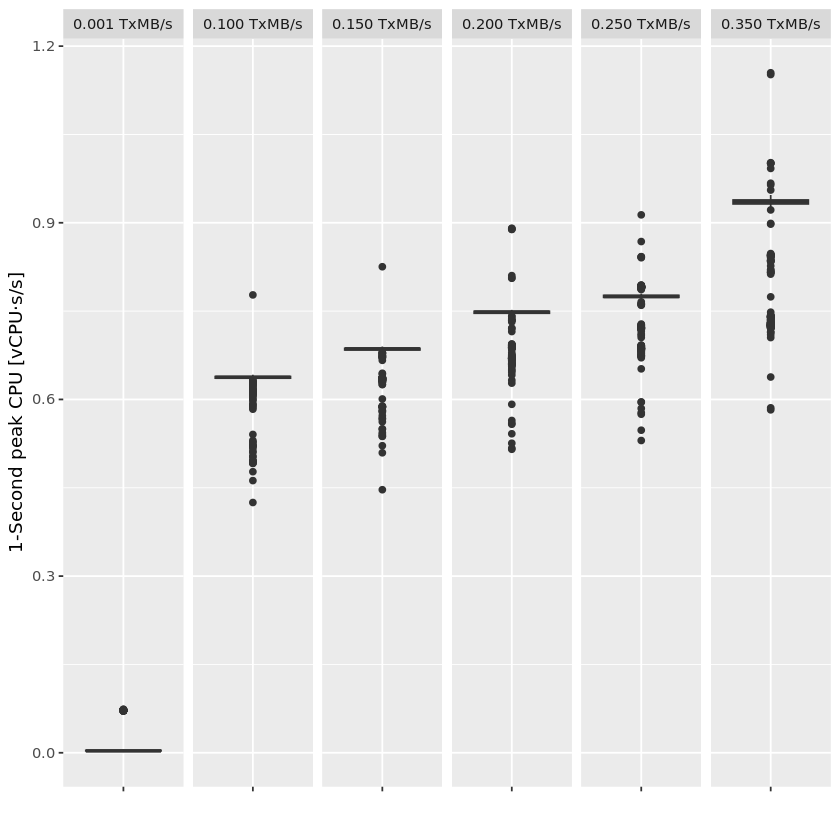

In [43]:
ggplot(
        resources[`VariedY` == yConstraint, .(`VariedX`, `VariedY`, `Node`, `1-Second peak CPU [vCPU⋅s/s]`=`Maximum CPU [s/s]`)], 
    aes(x="", y=`1-Second peak CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    facet_varied_x(wide=FALSE) +
    xlab("")

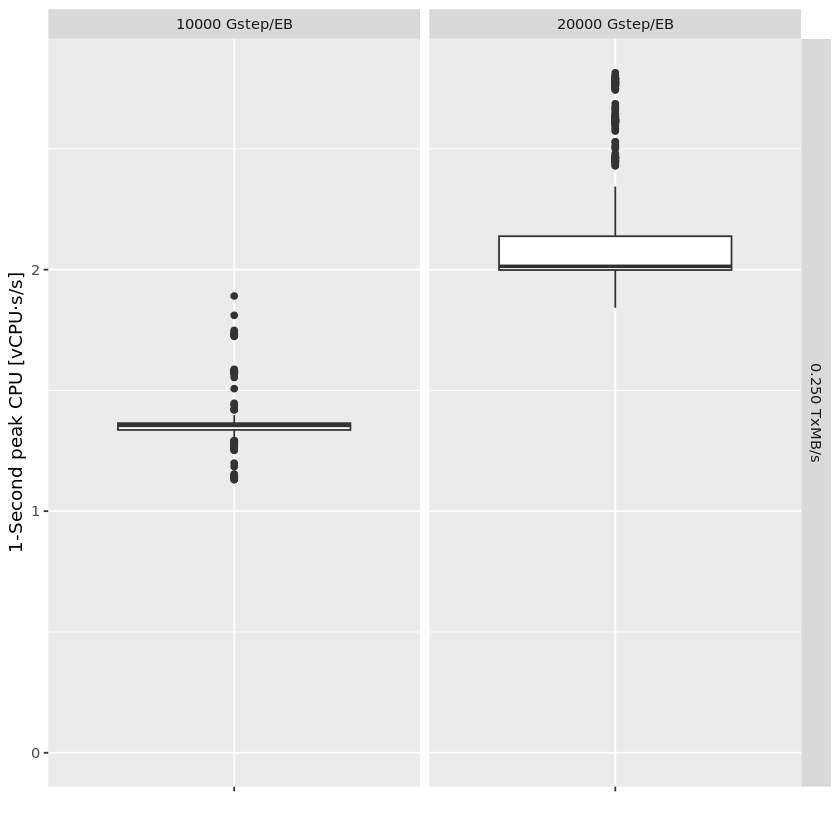

In [44]:
ggplot(
        resources[`VariedY` %in% c("10000 Gstep/EB", "20000 Gstep/EB", "50000 Gstep/EB"), .(`VariedX`, `VariedY`, `Node`, `1-Second peak CPU [vCPU⋅s/s]`=`Maximum CPU [s/s]`)], 
    aes(x="", y=`1-Second peak CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    facet_varied(wide=TRUE) +
    xlab("")

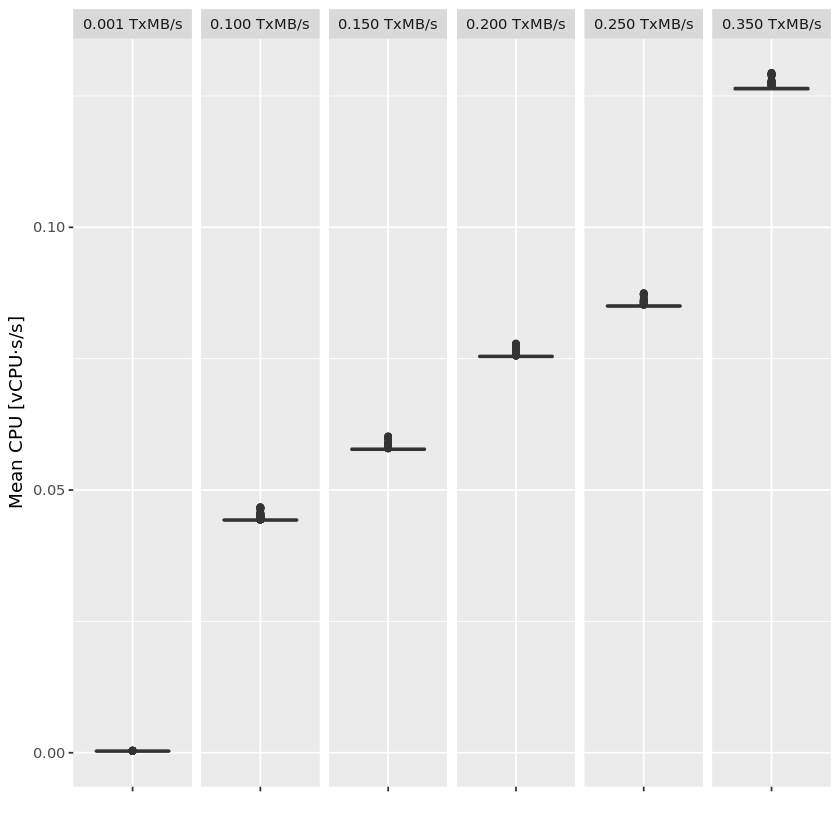

In [45]:
ggplot(
        resources[`VariedY` == yConstraint, .(`VariedX`, `VariedY`, `Node`, `Mean CPU [vCPU⋅s/s]`=`Total CPU [s]`/simFinish)], 
    aes(x="", y=`Mean CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    facet_varied_x(wide=FALSE) +
    xlab("")

#### Release memory

In [46]:
rm(resources)

In [47]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1020494,54.6,2446565,130.7,2446565,130.7
Vcells,1941027,14.9,25802867,196.9,50396222,384.5


### Receipt of messages

#### Read results

In [48]:
if (file.exists("results/receipts.Rdata")) {
    load("results/receipts.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    receipts <- fread("results/receipts.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
    save(receipts, file="results/receipts.Rdata")
    cat(paste("Saved Rdata file: sampleSize =", sampleSize, "\n"))
}
setnames(receipts, old="Kind", new="Message")
receipts <- receipts[`Throughput` != "0.300 TxMB/s"]
receipts %>% summary
receipts[, `:=`(
    `VariedX`=factor(`Throughput`),
    `VariedY`=factor(`Plutus`, levels=c("", "100 Gstep/EB", "200 Gstep/EB", "500 Gstep/EB", "1000 Gstep/EB", "2000 Gstep/EB"))
)]

Loaded Rdata file: sampleSize = 0.25 


        Network            Bandwidth                  CPU           
 topology-v2:277884238   10 Mb/s:277884238   4 vCPU/node:277884238  
                                                                    
                                                                    
                                                                    
                                                                    
                                                                    
                                                                    
        Diffusion duration            Voting duration        Max EB size       
 L_diff = 7 slots:277884238   L_vote = 4 slots:277884238   12 MB/EB:277884238  
                                                                               
                                                                               
                                                                               
                                                

In [49]:
kinds <- receipts[, unique(`Message`) %>% sort]
kinds

[1] EB RB TX VT
Levels: EB RB TX VT

#### Arrival histograms

##### Compare the distributions of elapsed times

In [50]:
arrivalDelayHistogram <- function(rs, kind, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
            rs[, .(`VariedX`, `VariedY`, `Elapsed [s]`, `Minute created`=factor(floor(`Generated [s]`/60)))],
        aes(x=`Elapsed [s]`, fill=`Minute created`)
    ) +
        geom_histogram(binwidth=0.1) +
        facet_varied_x(wide=TRUE, scales=scales) +
        xlab("Time from generation to receipt at node [s]") +
        ylab(paste("Number of", kind, " received")) +
        theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

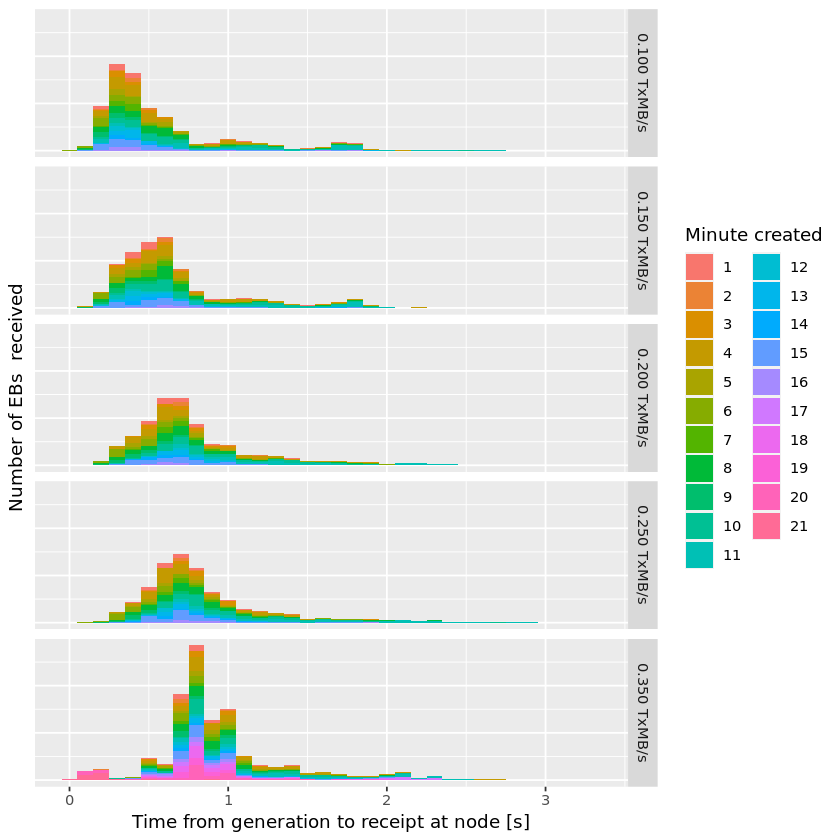

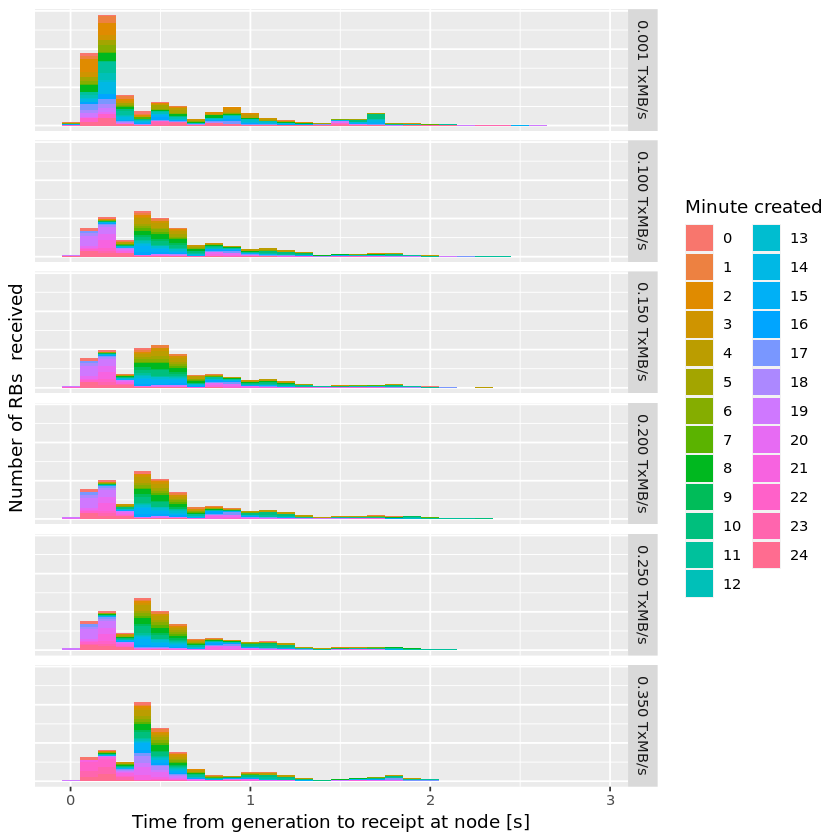

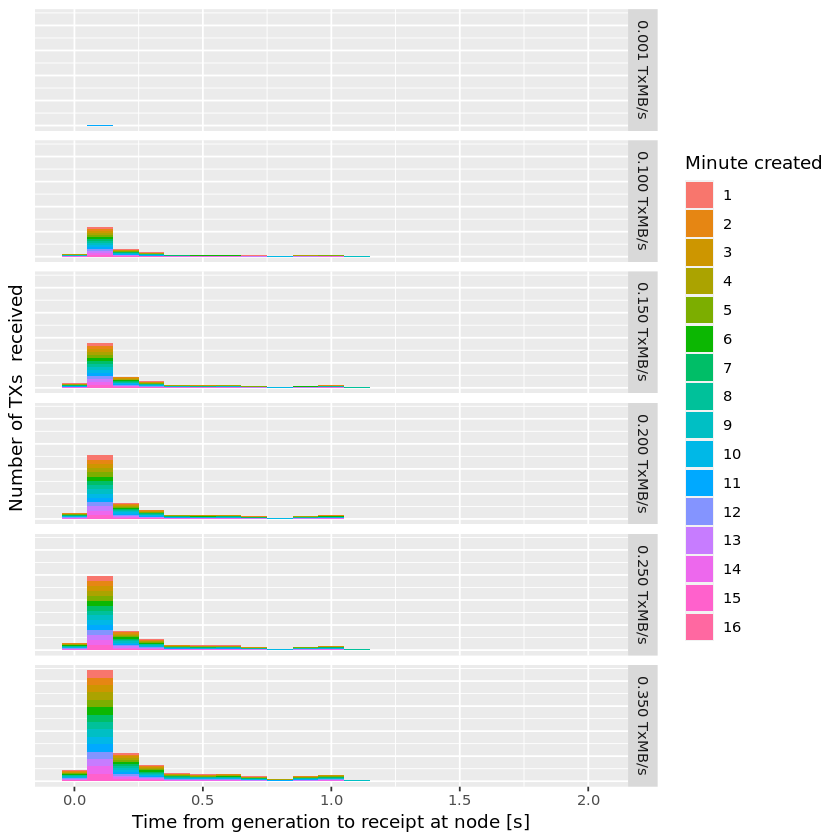

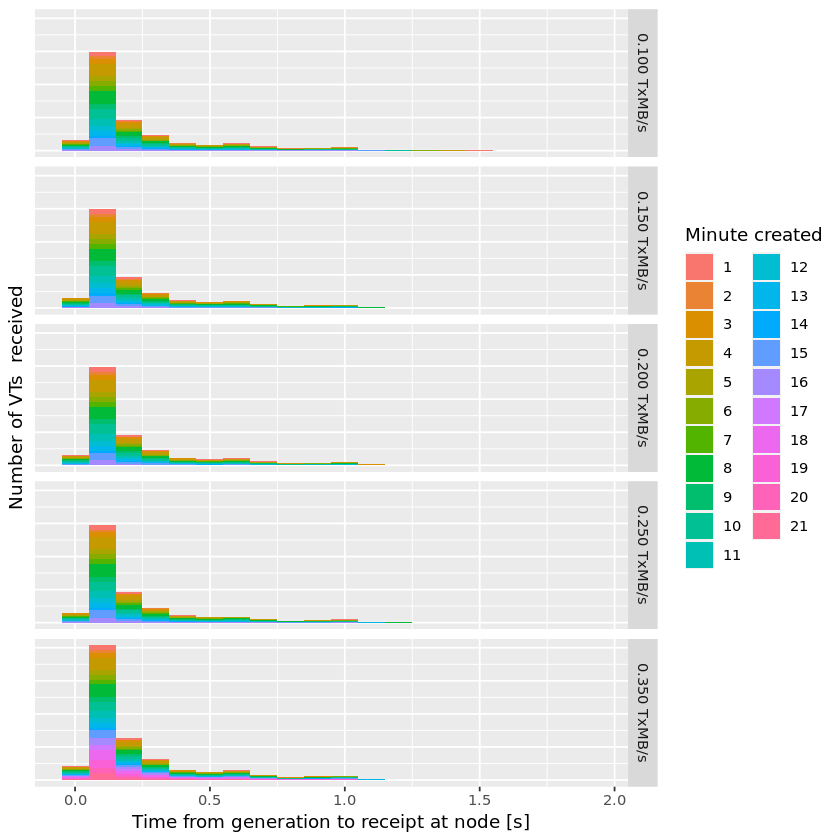

In [51]:
for (k in kinds)
    arrivalDelayHistogram(
        receipts[`VariedY` == yConstraint & `Message` == k],
        paste0(k, "s"),
        paste("Arrival delay for", k),
        scales="fixed",
        outfiles=c(paste0("plots/elapsed-", k, ".svg"), paste0("plots/elapsed-", k, ".png"))
    ) %>% print

#### Bandwidth usage

##### Total network bandwidth

In [52]:
totalBandwidthPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
            rs[,
                .(`Size [Gb]`=8*sum(`Size [B]`, rm.na=TRUE)/1e9/sampleSize),
                by=.(`VariedX`, `VariedY`, `Slot`=floor(`Received [s]`), `Message`)
            ],
        aes(x=`Slot`, y=`Size [Gb]`, fill=`Message`)
    ) +
        geom_area() +
        facet_varied_x(wide=TRUE, scales=scales) +
        xlab("Slot [s]") +
        ylab("Total network ingress [Gb/s]")
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

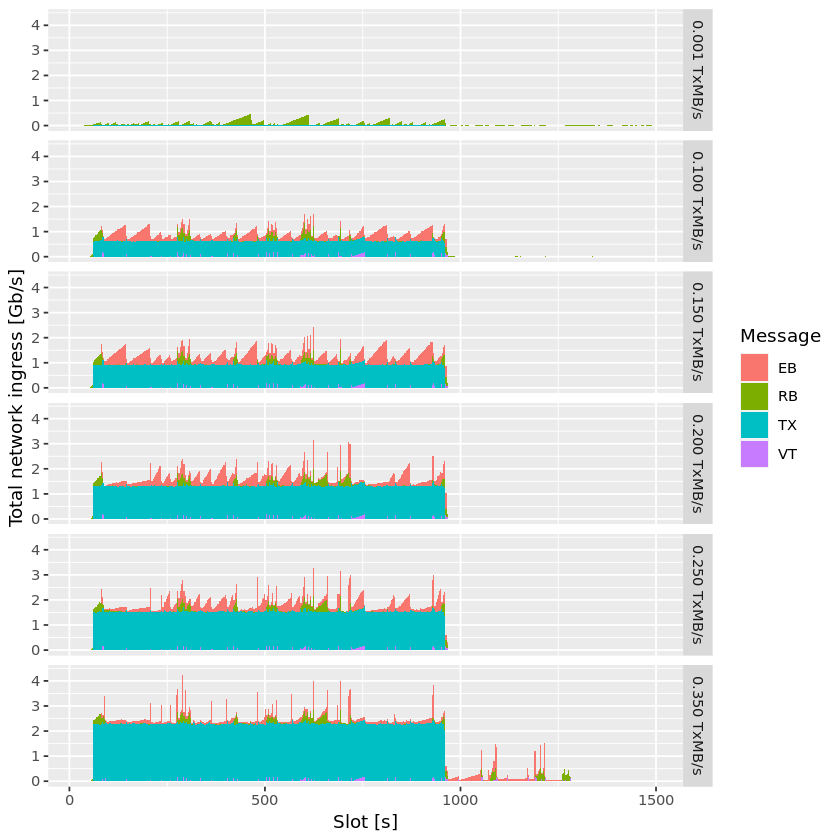

In [53]:
totalBandwidthPlot(
    receipts[`VariedY` == yConstraint],
    "Total bandwidth",
    scales="fixed"
)

##### Bandwidth usage per node

In [54]:
nodeCount <- receipts[, length(unique(`Recipient`))]
nodeCount

[1] 750

In [55]:
meanNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
            rs[,
                .(`Size [Mb/node]`=8*sum(`Size [B]`)/1e6/nodeCount/sampleSize),
                by=.(`VariedX`, `VariedY`, `Slot`=floor(`Received [s]`), `Message`)
            ],
        aes(x=`Slot`, y=`Size [Mb/node]`, fill=`Message`)
    ) +
        geom_area() +
        facet_varied_x(wide=TRUE, scales=scales) +
        xlab("Slot [s]") +
        ylab("Mean network ingress among nodes [Mb/s]")
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

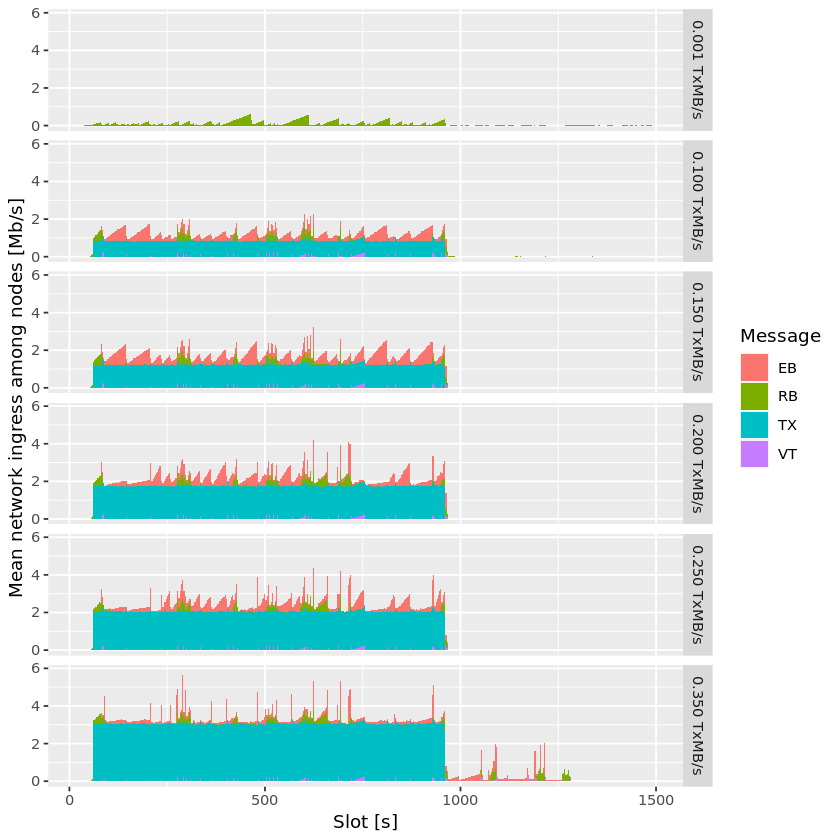

In [56]:
meanNodalIngressPlot(
    receipts[`VariedY` == yConstraint], 
    "Mean nodal ingress",
    scales="fixed",
    outfiles=c(paste0("plots/ingress-average-area.svg"), paste0("plots/ingress-average-area.png"))
)

In [57]:
peakNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
            rs[,
                .(`Size [Mb]`=8*sum(`Size [B]`, rm.na=TRUE)/1e6/sampleSize),
                by=.(`VariedX`, `VariedY`, `Slot`=floor(`Received [s]`), `Message`, `Recipient`)
            ][,
                .(`Size [Mb]`=max(`Size [Mb]`)),
                by=.(`VariedX`, `VariedY`, `Slot`, `Message`)
            ],
        aes(x=`Slot`, y=`Size [Mb]`, color=`Message`)
    ) +
        geom_point(size=0.5) +
        facet_varied_x(scales=scales) +
        xlab("Slot [s]") +
        ylab("Maximum network ingress among nodes [Mb/s]")
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

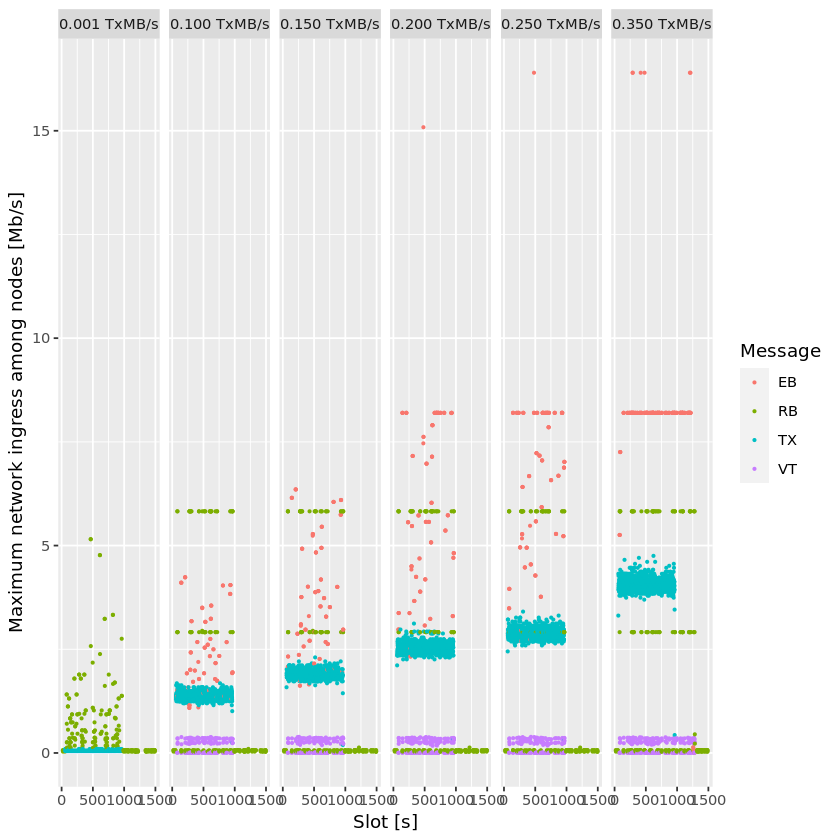

In [58]:
peakNodalIngressPlot(
    receipts[`VariedY` == yConstraint], 
    "Peak nodal ingress"
)

#### Summary for cost estimates

In [59]:
egressSummary <- receipts[
    `VariedY` == yConstraint &
    `Generated [s]` >= txFirst + 30 &
    `Generated [s]` < txLast - 30,
    .(
        `Egress [MB/s/node]` = sum(`Size [B]`, rm.na=TRUE) / sampleSize / 1e6 / (txLast - txFirst - 2 * 30) / nodeCount
    ),
    .(`VariedX`, `VariedY`)
]
egressSummary

VariedX,VariedY,Egress [MB/s/node]
<fct>,<fct>,<dbl>
0.100 TxMB/s,,0.106539231
0.150 TxMB/s,,0.158138498
0.200 TxMB/s,,0.225548656
0.250 TxMB/s,,0.261945649
0.001 TxMB/s,,0.002329869
0.350 TxMB/s,,0.389082721


#### Release memory

In [60]:
rm(receipts)

In [61]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1270786,67.9,2975878,159.0,2975878,159.0
Vcells,1696750381,12945.2,8657816520,66053.9,9018484616,68805.6


### CPU usage

#### Read results

In [62]:
if (file.exists("results/cpus.Rdata")) {
    load(file="results/cpus.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    cpus <- fread("results/cpus.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
    save(cpus, file="results/cpus.Rdata")
    cat(paste("Saved Rdata file: sampleSize =", sampleSize, "\n"))
}
cpus <- cpus[`Throughput` != "0.300 TxMB/s"]
cpus %>% summary
cpus[, `:=`(
    `VariedX`=factor(`Throughput`),
    `VariedY`=factor(`Plutus`, levels=c("", "1000 Gstep/EB", "2000 Gstep/EB", "5000 Gstep/EB", "10000 Gstep/EB", "20000 Gstep/EB", "50000 Gstep/EB"))
)]

Loaded Rdata file: sampleSize = 0.25 


        Network            Bandwidth                  CPU           
 topology-v2:278136643   10 Mb/s:278136643   4 vCPU/node:278136643  
                                                                    
                                                                    
                                                                    
                                                                    
                                                                    
                                                                    
        Diffusion duration            Voting duration        Max EB size       
 L_diff = 7 slots:278136643   L_vote = 4 slots:278136643   12 MB/EB:278136643  
                                                                               
                                                                               
                                                                               
                                                

In [63]:
cpusNode <-
        cpus[
            ,
            .(`Duration [s]`=sum(`Duration [s]`)),
            by=.(`VariedX`, `VariedY`, `Node`, `Slot`)
        ]

In [64]:
nodeCount <- cpusNode[, length(unique(`Node`))]
nodeCount

[1] 750

#### Peak CPU usage

##### Histogram

In [65]:
peakCpuHistogram <- function(cs, title="", wide=TRUE, scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
            cs[,
                .(`Duration [%]`=100*max(`Duration [s]`)),
                by=.(`VariedX`, `VariedY`, `Slot`)
            ], 
        aes(x=`Duration [%]`)
    ) +
        geom_histogram(binwidth=10) +
        facet_varied(wide, scales=scales) +
        xlab("Peak CPU load [%]") +
        ylab("Number of slots")
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

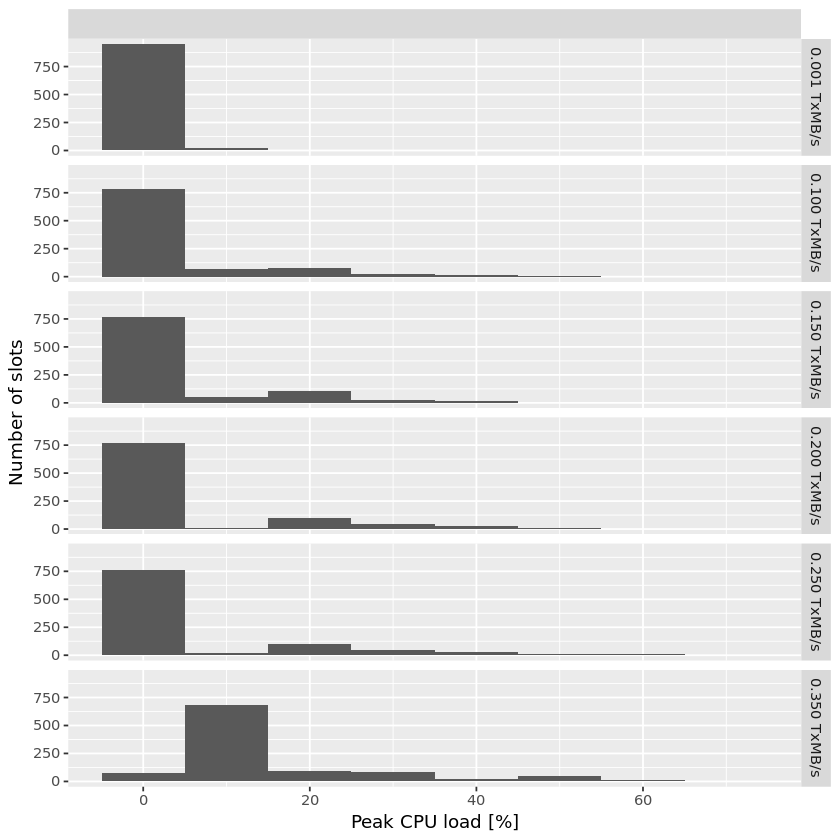

In [66]:
peakCpuHistogram(
    cpusNode[`VariedY` == yConstraint], 
    "Peak CPU load among all nodes",
    scales="fixed"
)

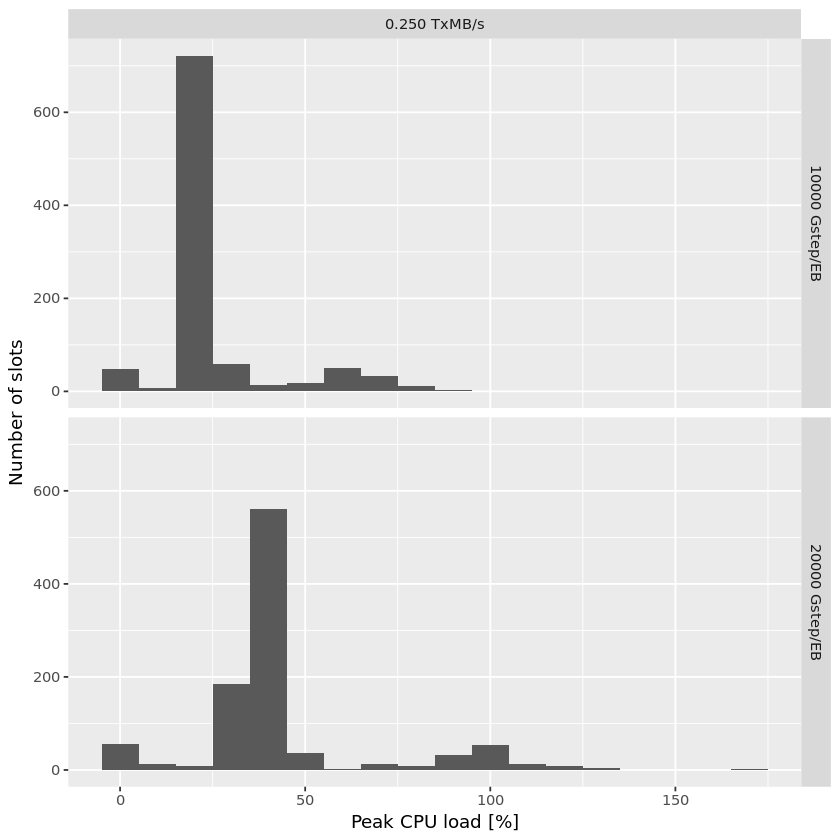

In [67]:
peakCpuHistogram(
    cpusNode[`VariedY` %in% c("10000 Gstep/EB", "20000 Gstep/EB", "50000 Gstep/EB")], 
    "Peak CPU load among all nodes",
    wide=FALSE,
    scales="fixed",
    c("plots/plutus-cpu-peak-histogram.svg", "plots/plutus-cpu-peak-histogram.png")
)

##### Time series

In [68]:
peakCpuTimeseries <- function(cs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
            cs[,
                .(`Duration [%]`=100*mean(`Duration [s]`)/sampleSize),
                by=.(`VariedX`, `VariedY`, `Slot`)
            ], 
        aes(x=`Slot`, y=`Duration [%]`)) +
        geom_line() +
        facet_varied_x(wide=TRUE, scale=scales) +
        xlab("Slot") +
        ylab("Mean CPU load [%]")
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

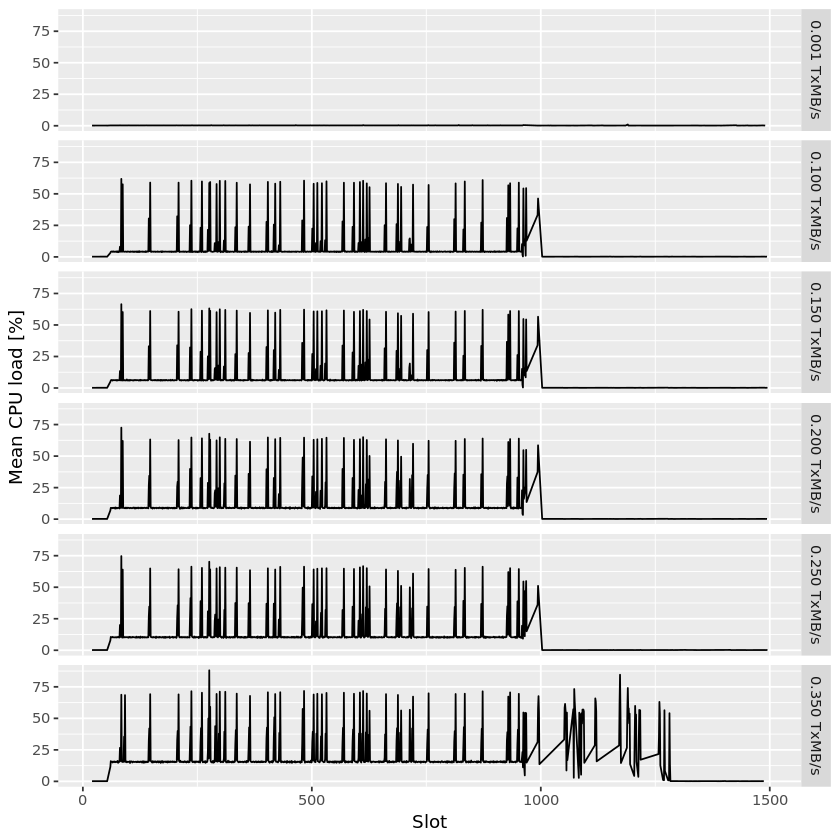

In [69]:
peakCpuTimeseries(
    cpusNode[`VariedY` == yConstraint],
    "Mean CPU load among all nodes",
    outfiles=c("plots/cpu-mean-timeseries.svg", "plots/cpu-mean-timeseries.png")
)

#### Mean CPU usage

##### Histogram

In [70]:
meanCpuHistogram <- function(cs, nodeSeconds, title="", scales="fixed", wide=FALSE, outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
            cs[,
                .(`Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds/nodeCount),
                by=.(`VariedX`, `VariedY`, `Task`)
            ], 
        aes(x="", fill=`Task`, y=`Duration [%]`)) +
        geom_bar(stat = "identity") +
        facet_varied(wide=wide, scales=scales) +
        xlab("") +
        ylab("Mean CPU load [%]")
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

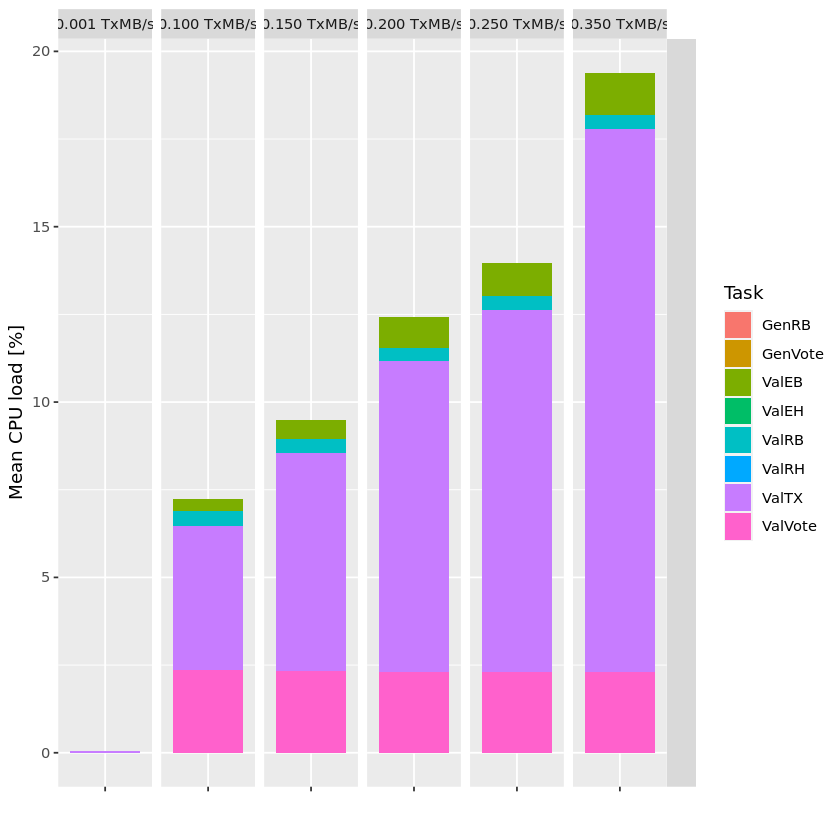

In [71]:
meanCpuHistogram(
    cpus[`VariedY` == yConstraint & `Slot` >= txFirst & `Slot` < txLast],
    txWindow * sampleSize, 
    "Mean CPU load among all nodes", 
    scales="fixed",
    outfiles=c(paste0("plots/cpu-mean-histogram.svg"), paste0("plots/cpu-mean-histogram.png"))
)

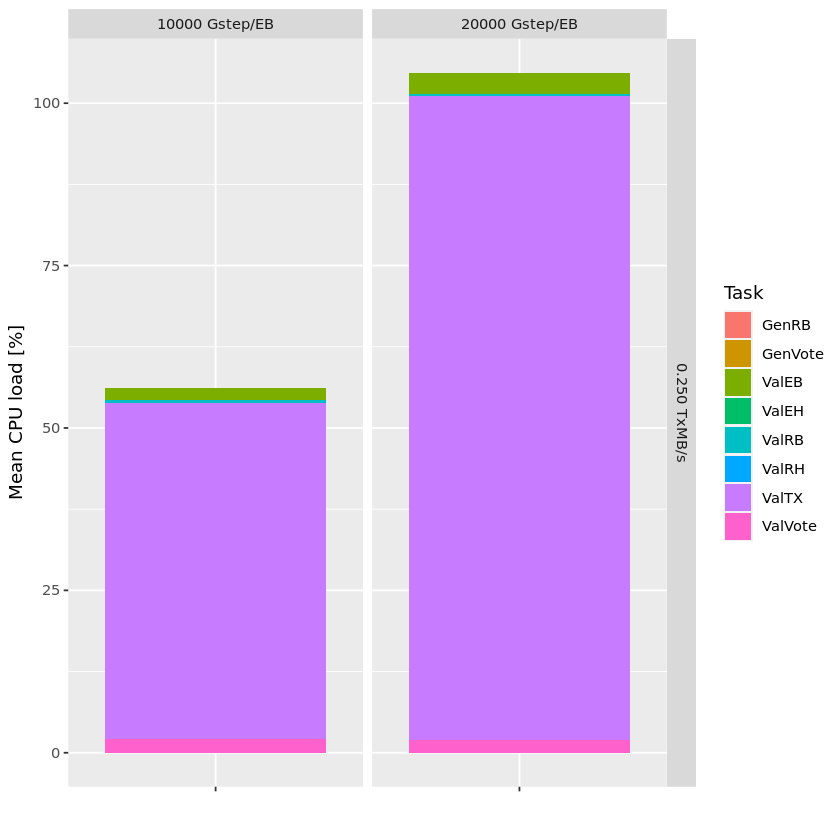

In [72]:
meanCpuHistogram(
    cpus[
        `VariedY` %in% c("10000 Gstep/EB", "20000 Gstep/EB", "50000 Gstep/EB") & `Slot` >= txFirst & `Slot` < txLast,
        .(
            `VariedX`,
            `VariedY`,
            `Task`,
            `Duration [s]`
        )
    ],
    txWindow * sampleSize, 
    "Mean CPU load among all nodes", 
    scales="fixed",
    wide=TRUE,
    outfiles=c(paste0("plots/plutus-cpu-mean-histogram.svg"), paste0("plots/plutus-cpu-mean-histogram.png"))
) 

##### Time series

In [73]:
meanCpuTimeseries <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
            cs[,
                .(`Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds/nodeCount/sampleSize),
                by=.(`VariedX`, `VariedY`, `Slot`, `Task`)
            ], 
        aes(x=`Slot`, y=`Duration [%]`, color=`Task`)
    ) +
        geom_point(size=0.25, alpha=0.75) +
        facet_varied_x(wide=TRUE, scales=scales) +
        scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]")
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

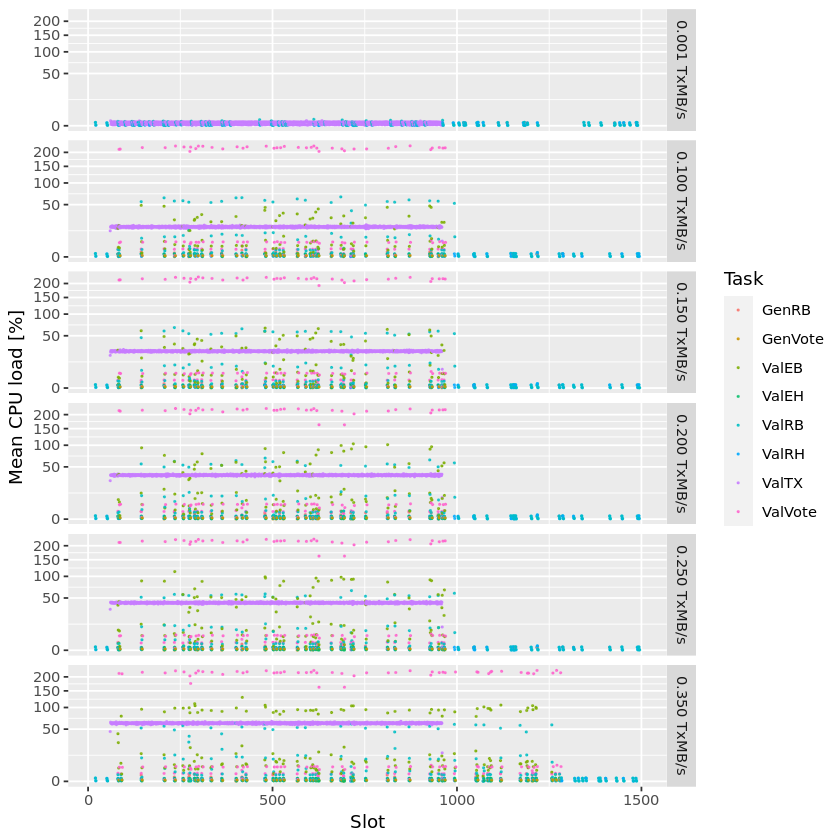

In [74]:
meanCpuTimeseries(
    cpus[`VariedY` == yConstraint], 
    sampleSize, 
    "Mean CPU load among all nodes"
)

#### Summary for cost estimates

In [75]:
cpusSummary <- cpus[
    `VariedY` == yConstraint &
    `Slot` >= txFirst + 30 &
    `Slot` < txLast - 30,
    .(
        `Mean cores [vCPU/node]`=sum(`Duration [s]`) / sampleSize / nodeCount / (txLast - txFirst - 2 * 30),
        `Peak cores [vCPU/node]`=max(`Duration [s]`)
    ),
    .(`VariedX`, `VariedY`)
]
cpusSummary

VariedX,VariedY,Mean cores [vCPU/node],Peak cores [vCPU/node]
<fct>,<fct>,<dbl>,<dbl>
0.100 TxMB/s,,0.0715111424,0.2073869
0.150 TxMB/s,,0.0938288177,0.2733209
0.200 TxMB/s,,0.1230533216,0.3393539
0.250 TxMB/s,,0.1386961852,0.3393539
0.001 TxMB/s,,0.0005049406,0.0720009
0.350 TxMB/s,,0.1936787098,0.3393539


#### Release memory

In [76]:
rm(cpus, cpusNode)

In [77]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1040299,55.6,2975878,159.0,2975878,159.0
Vcells,1241470241,9471.7,6926253216,52843.2,9018484616,68805.6


### Block contents

### Read data

In [78]:
if (file.exists("results/sizes.Rdata")) {
    load(file="results/sizes.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    sizes <- fread("results/sizes.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
    save(sizes, file="results/sizes.Rdata")
    cat(paste("Saved Rdata file: sampleSize =", sampleSize, "\n"))
}
setnames(sizes, old="Kind", new="Message")
sizes <- sizes[`Throughput` != "0.300 TxMB/s"]
sizes %>% summary
sizes[, `:=`(
    `VariedX`=factor(`Throughput`),
    `VariedY`=factor(`Plutus`, levels=c("", "1000 Gstep/EB", "2000 Gstep/EB", "5000 Gstep/EB", "10000 Gstep/EB", "20000 Gstep/EB", "50000 Gstep/EB"))
)]

Loaded Rdata file: sampleSize = 1 


        Network       Bandwidth             CPU              Diffusion duration
 topology-v2:1247   10 Mb/s:1247   4 vCPU/node:1247   L_diff = 7 slots:1247    
                                                                               
                                                                               
                                                                               
                                                                               
                                                                               
                                                                               
         Voting duration   Max EB size        Tx size            Throughput 
 L_vote = 4 slots:1247   12 MB/EB:1247   1500 B/Tx:1247   0.001 TxMB/s: 80  
                                                          0.100 TxMB/s:112  
                                                          0.150 TxMB/s:112  
                                                    

In [79]:
txSize <- sizes[, as.numeric(sub(" .*$", "", unique(`Tx size`)))]
txSize

[1] 1500

### EB contents

#### Transactions

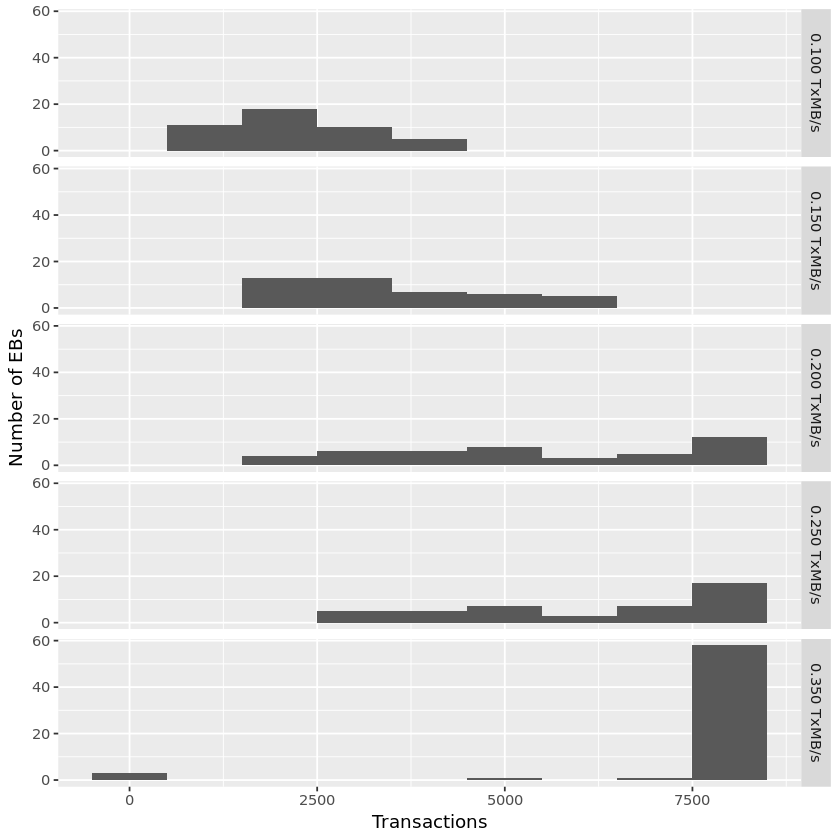

In [80]:
ggplot(sizes[`VariedY` == yConstraint & `Message` == "EB" & `Transactions` > 0], aes(x=`Transactions`)) +
    geom_histogram(binwidth=1000) +
    facet_varied_x(wide=TRUE) +
    ylab("Number of EBs")

#### Sizes

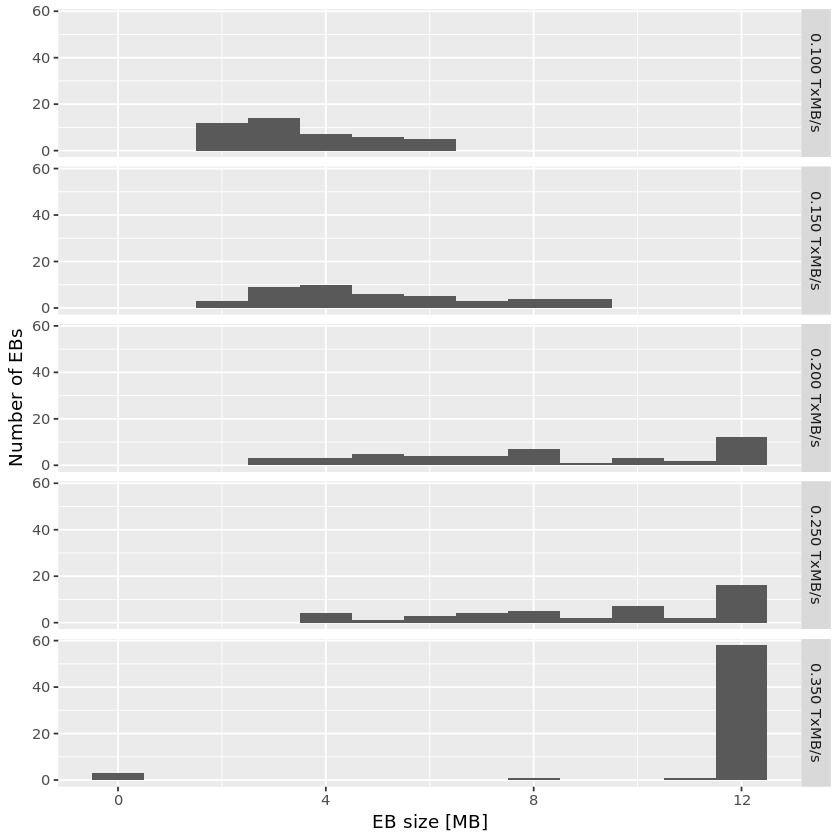

In [81]:
ggplot(
        sizes[`VariedY` == yConstraint & `Message` == "EB" & `Transactions` > 0, .(`EB size [MB]`=`Transactions`*txSize/1e6), .(`VariedX`, `VariedY`)], 
    aes(x=`EB size [MB]`)
) +
    geom_histogram(binwidth=1) +
    facet_varied_x(wide=TRUE) +
    ylab("Number of EBs")

In [82]:
ggsave("plots/contents-ebs-size.svg", units="in", dpi=150, width=16, height=8)

In [83]:
ggsave("plots/contents-ebs-size.png", units="in", dpi=150, width=16, height=8)

### RB contents

#### Transactions

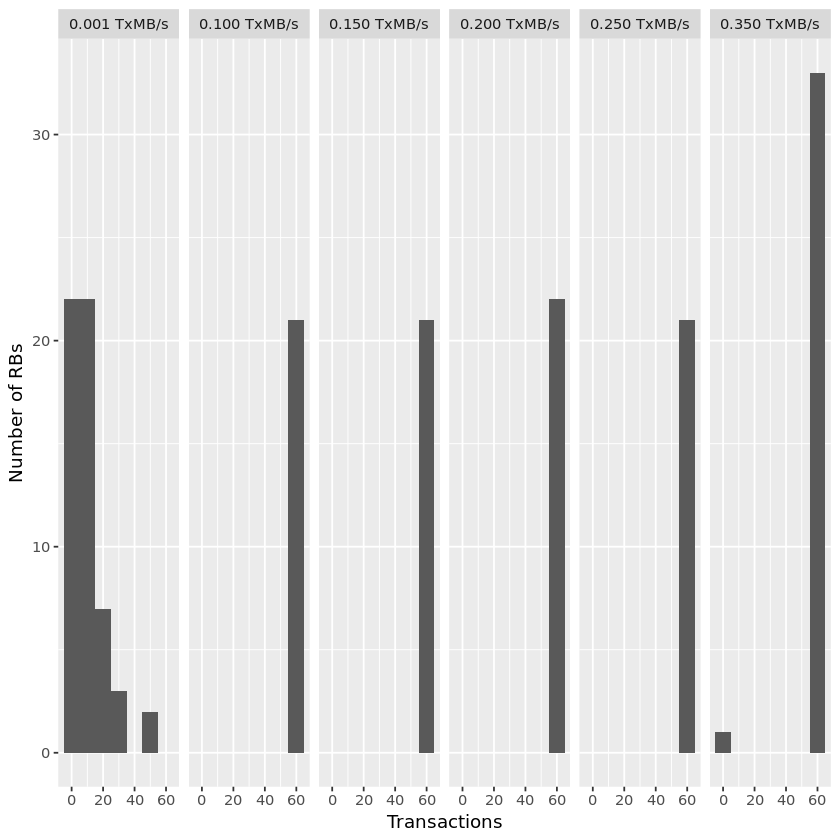

In [84]:
ggplot(sizes[`VariedY` == yConstraint & `Message` == "RB" & `Transactions` > 0], aes(x=`Transactions`)) +
    geom_histogram(binwidth=10) +
    facet_varied_x() +
    ylab("Number of RBs")

#### Sizes

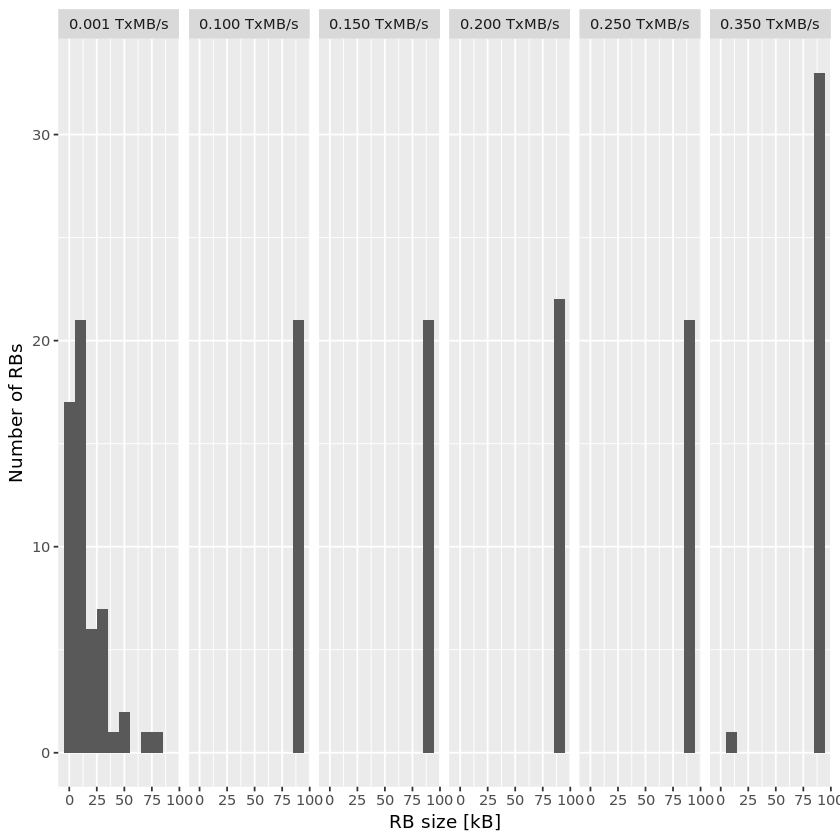

In [85]:
ggplot(
        sizes[`VariedY` == yConstraint & `Message` == "RB" & `Transactions` > 0, .(`RB size [kB]`=`Transactions`*txSize/1e3), .(`VariedX`, `VariedY`)],
    aes(x=`RB size [kB]`)
) +
    geom_histogram(binwidth=10) +
    facet_varied_x() +
    ylab("Number of RBs")

### Disposition of blocks

#### Data processing

In [86]:
ebSizes <- 
        sizes[`Message` == "RB" & !is.na(`Endorses`), .(`Certified`=TRUE), .(`VariedX`, `VariedY`, `Item`=`Endorses`)][
        sizes[`Message` == "EB", .(`EB Transactions`=`Transactions`), .(`VariedX`, `VariedY`, `Item`)], 
            on=c("VariedX", "VariedY", "Item")
        ][
            ,
            .(
                `EB txs later not certified`=ifelse(is.na(`Certified`), as.numeric(`EB Transactions`), 0),
                `EB txs later certified`=ifelse(is.na(`Certified`), 0, as.numeric(`EB Transactions`))
            ),
            .(`VariedX`, `VariedY`, `Item`)
        ]

In [87]:
rbSizes <- 
        ebSizes[
            ebSizes[, .(`EB txs certified now`=`EB txs later certified`), .(`VariedX`, `VariedY`, `Endorses`=`Item`)][
                sizes[`Message` == "RB", .(`Generated [s]`, `RB Transactions`=as.numeric(`Transactions`)), .(`VariedX`, `VariedY`, `Item`, `Endorses`)],
                on=c("VariedX", "VariedY", "Endorses")
            ],
            on=c("VariedX", "VariedY", "Item"),
            nomatch=0
        ][
            ,
            .(
                `Generated [s]`,
                `RB`=`RB Transactions`,
                `EB later not certified`=`EB txs later not certified`,
                `EB later certified`=`EB txs later certified`,
                `EB now certified`=ifelse(is.na(`EB txs certified now`), 0, `EB txs certified now`)
            ),
            , .(`VariedX`, `VariedY`, `Item`)
        ]

In [88]:
blocks <- melt(
    rbSizes, 
    id.vars=c("VariedX", "VariedY", "Item", "Generated [s]"),
    measure.vars=c("RB", "EB later not certified", "EB later certified", "EB now certified"),
    variable.name="Block",
    value.name="Transactions"
)

#### Sanity checks

In [89]:
ebSizes[, .N] == sizes[`Message` == "EB", .N]

[1] TRUE

In [90]:
ebSizes[, sum(`EB txs later not certified`) + sum(`EB txs later certified`)] == sizes[`Message` == "EB", sum(`Transactions`)]

[1] TRUE

In [91]:
rbSizes[, .N] == sizes[`Message` == "RB", .N]

[1] FALSE

In [92]:
rbSizes[, sum(`RB`)] == sizes[`Message` == "RB", sum(`Transactions`)]

[1] FALSE

In [93]:
rbSizes[, sum(`EB later not certified`) + sum(`EB later certified`)] == sizes[`Message` == "EB", sum(`Transactions`)]

[1] TRUE

In [94]:
# TODO: Compute precise equality that accounts for forks.
rbSizes[, sum(`EB later certified`)] <= rbSizes[, sum(`EB now certified`)]

[1] TRUE

#### Transactions

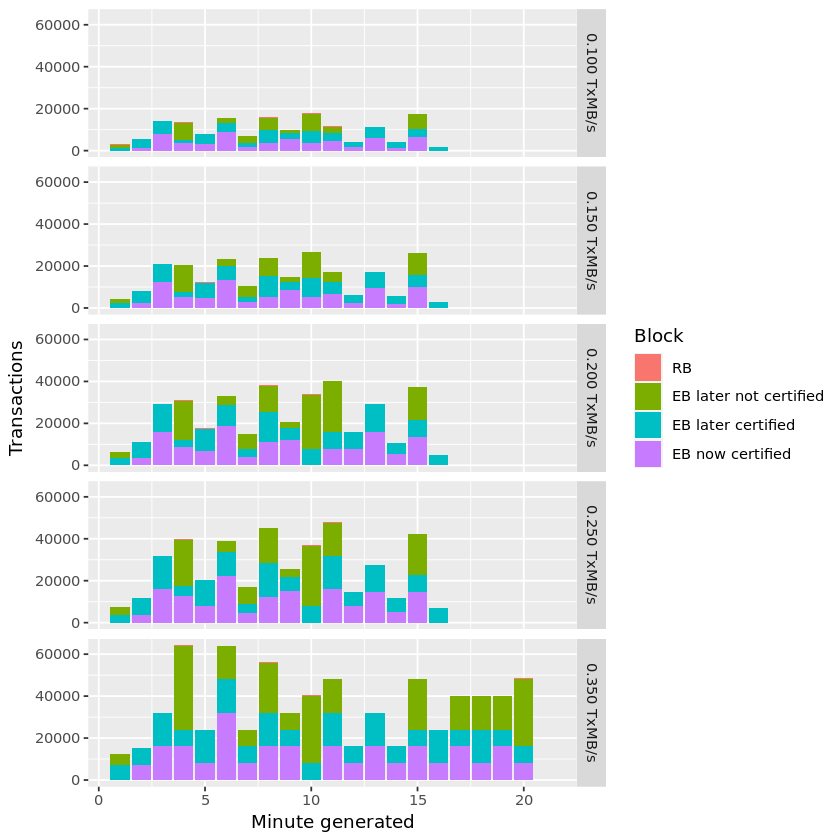

In [95]:
ggplot(
        blocks[`VariedY` == yConstraint, .(`Transactions`=sum(`Transactions`)), .(`VariedX`, `VariedY`, `Block`, `Minute generated`=(floor(`Generated [s]`/60)))],
    aes(x=`Minute generated`, y=`Transactions`, fill=`Block`)
) +
    geom_bar(stat="identity") +
    facet_varied_x(wide=TRUE)

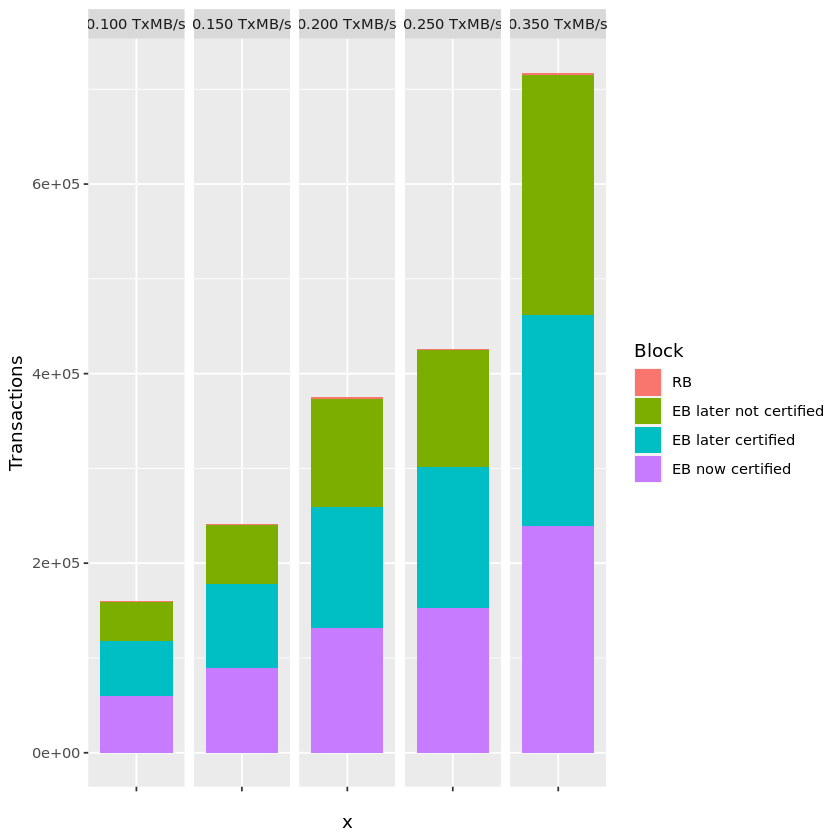

In [96]:
ggplot(
        blocks[`VariedY` == yConstraint, .(`Transactions`=sum(`Transactions`)), .(`VariedX`, `VariedY`, `Block`)],
    aes(x="", y=`Transactions`, fill=`Block`)
) +
    geom_bar(stat="identity") +
    facet_varied_x()

#### Sizes

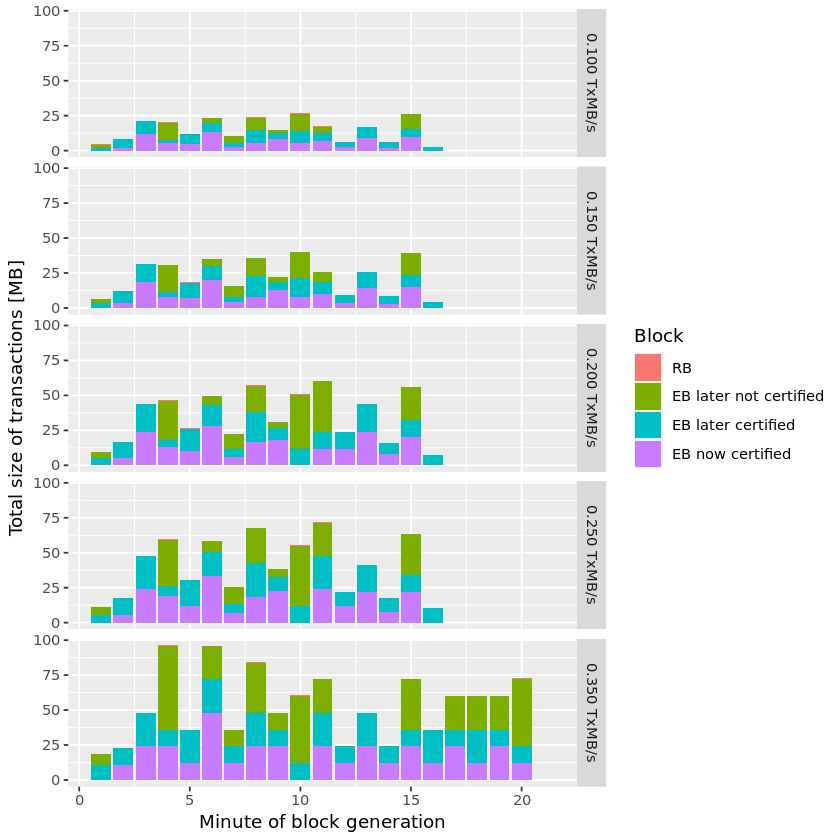

In [97]:
ggplot(
        blocks[`VariedY` == yConstraint, .(`Total size of transactions [MB]`=sum(`Transactions`)*txSize/1e6), .(`VariedX`, `VariedY`, `Block`, `Minute of block generation`=(floor(`Generated [s]`/60)))], 
    aes(x=`Minute of block generation`, y=`Total size of transactions [MB]`, fill=`Block`)
) +
    geom_bar(stat="identity") +
    facet_varied_x(wide=TRUE)

In [98]:
ggsave("plots/disposition-size-timeseries.svg", units="in", dpi=150, width=16, height=8)

In [99]:
ggsave("plots/disposition-size-timeseries.png", units="in", dpi=150, width=16, height=8)

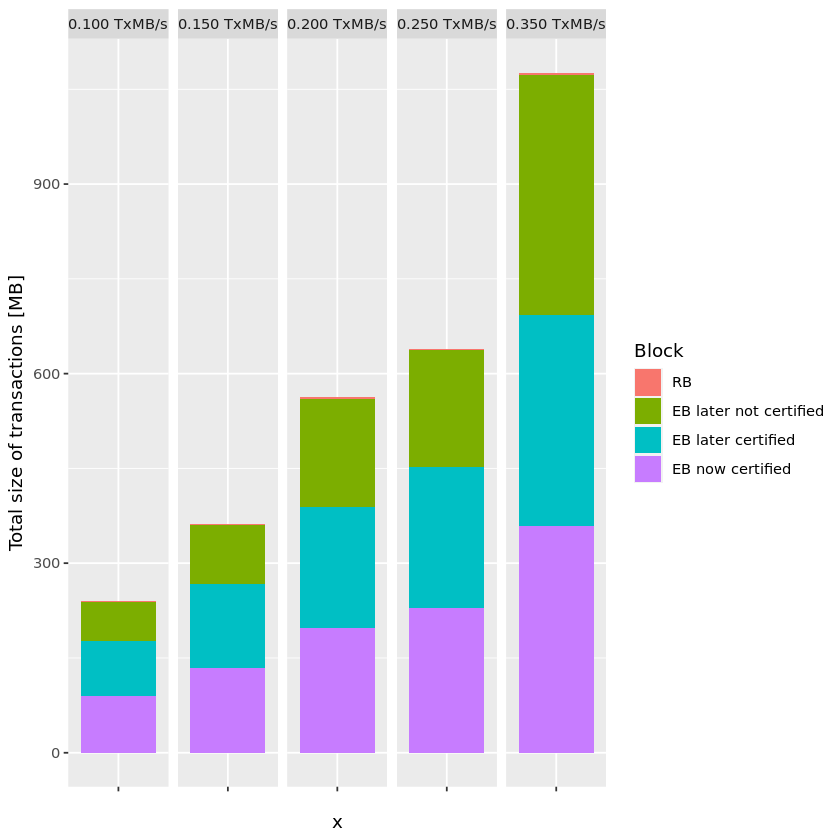

In [100]:
ggplot(
        blocks[`VariedY` == yConstraint, .(`Total size of transactions [MB]`=sum(`Transactions`)*txSize/1e6), .(`VariedX`, `VariedY`, `Block`)], 
    aes(x="", y=`Total size of transactions [MB]`, fill=`Block`)
) +
    geom_bar(stat="identity") +
    facet_varied_x()

#### Release memory

In [101]:
rm(sizes, ebSizes, rbSizes, blocks)

In [102]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1040960,55.6,2975878,159.0,2975878,159.0
Vcells,2128035,16.3,5541002573,42274.5,9018484616,68805.6


## Cost estimate

In [103]:
usage <- cpusSummary[diskSummary[egressSummary, on=c("VariedX" , "VariedY")], on=c("VariedX" , "VariedY")][, .(
    `Throughput [TxMB/s]`=as.numeric(sub(" .*$", "",`VariedX`)),
    `TPS (avg-sized txs)`=as.numeric(sub(" .*$", "",`VariedX`))/txSize*1e6,
    `TPS (small txs)`=as.numeric(sub(" .*$", "",`VariedX`))/0.000300,
    `CPU [vCPU]`=ceiling(`Peak cores [vCPU/node]`),
    `Disk [GB/mo]`=`Disk [MB/s/node]`/1e3*(365.24/12)*24*60*60,
    `Egress [GB/mo]`=`Egress [MB/s/node]`/1e3*(365.24/12)*24*60*60,
    `DMY`=TRUE
)]
usage

Throughput [TxMB/s],TPS (avg-sized txs),TPS (small txs),CPU [vCPU],Disk [GB/mo],Egress [GB/mo],DMY
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
0.100,66.6666667,333.333333,1,268.140391,280.169198,TRUE
0.150,100.0000000,500.000000,1,402.251610,415.861237,TRUE
0.200,133.3333333,666.666667,1,574.673508,593.131617,TRUE
0.250,166.6666667,833.333333,1,670.473598,688.845808,TRUE
0.001,0.6666667,3.333333,1,2.629728,6.126921,TRUE
0.350,233.3333333,1166.666667,1,1001.389653,1023.181727,TRUE


In [104]:
pricing <- data.table(
    `Provider`            =c("Google Cloud", "Railway",  "AWS", "Microsoft Azure", "Alibaba Cloud", "DigitalOcean", "Oracle Cloud", "Linode", "Hetzner", "Upcloud"),
    `Egress [USD/GB]`     =c(         0.120,     0.100,  0.090,             0.087,           0.074,          0.010,         0.0085,    0.005,   0.00108,     0.000),
    `Free egress [GB/mo]` =c(             0,         0,    100,               100,              10,            100,          10240,     1024,      1024,      1024),
    `4 vCPU 16GB [USD/mo]`=c(        152.35,    161.88, 124.10,            123.37,          172.28,           84.0,          33.00,     60.0,     17.80,     65.12),
    `Disk [USD/GB/mo]`    =c(         0.040,     0.150,  0.080,             0.075,           0.050,          0.100,         0.0425,    0.100,     0.046,     0.056),
    DMY=TRUE
)
pricing

Provider,Egress [USD/GB],Free egress [GB/mo],4 vCPU 16GB [USD/mo],Disk [USD/GB/mo],DMY
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
Google Cloud,0.12000,0,152.35,0.0400,TRUE
Railway,0.10000,0,161.88,0.1500,TRUE
AWS,0.09000,100,124.10,0.0800,TRUE
Microsoft Azure,0.08700,100,123.37,0.0750,TRUE
Alibaba Cloud,0.07400,10,172.28,0.0500,TRUE
DigitalOcean,0.01000,100,84.00,0.1000,TRUE
Oracle Cloud,0.00850,10240,33.00,0.0425,TRUE
Linode,0.00500,1024,60.00,0.1000,TRUE
Hetzner,0.00108,1024,17.80,0.0460,TRUE


In [105]:
estimate <- pricing[usage, on="DMY", allow.cartesian=TRUE][, .(
    `Provider`,
    `Throughput [TxMB/s]`,
    `TPS (avg-sized txs)`,
    `TPS (small txs)`,
    `Compute [USD/mo]`=`4 vCPU 16GB [USD/mo]`,
    `Egress [USD/mo]`=`Egress [USD/GB]` * ifelse(`Egress [GB/mo]` > `Free egress [GB/mo]`, `Egress [GB/mo]` - `Free egress [GB/mo]`, 0),
    `Disk [USD/mo/mo]`=`Disk [USD/GB/mo]` * `Disk [GB/mo]`
)][
    ,
    .(
        `Min operating cost [USD/mo]`=min(`Compute [USD/mo]` + `Egress [USD/mo]`, na.rm=TRUE),
        `Median operating cost [USD/mo]`=median(`Compute [USD/mo]` + `Egress [USD/mo]`, na.rm=TRUE),
        `Max operating cost [USD/mo]`=max(`Compute [USD/mo]` + `Egress [USD/mo]`, na.rm=TRUE),
        `Min storage cost [USD/mo/mo]`=min(`Disk [USD/mo/mo]`, na.rm=TRUE),
        `Median storage cost [USD/mo/mo]`=median(`Disk [USD/mo/mo]`, na.rm=TRUE),
        `Max storage cost [USD/mo/mo]`=max(`Disk [USD/mo/mo]`, na.rm=TRUE)
    ),
    .(`Throughput [TxMB/s]`, `TPS (avg-sized txs)`, `TPS (small txs)`)
]
estimate

Throughput [TxMB/s],TPS (avg-sized txs),TPS (small txs),Min operating cost [USD/mo],Median operating cost [USD/mo],Max operating cost [USD/mo],Min storage cost [USD/mo/mo],Median storage cost [USD/mo/mo],Max storage cost [USD/mo/mo]
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.100,66.6666667,333.333333,17.8,112.4232,192.2725,10.7256156,17.5631956,40.2210586
0.150,100.0000000,500.000000,17.8,119.0043,203.4661,16.0900644,26.3474805,60.3377415
0.200,133.3333333,666.666667,17.8,127.6019,223.5258,22.9869403,37.6411148,86.2010262
0.250,166.6666667,833.333333,17.8,132.2440,235.0115,26.8189439,43.9160206,100.5710396
0.001,0.6666667,3.333333,17.8,103.6850,172.2800,0.1051891,0.1722472,0.3944592
0.350,233.3333333,1166.666667,17.8,148.4593,275.1318,40.0555861,65.5910223,150.2084480


In [106]:
estimate[, .(
    `Throughput`=sprintf("%.0f TxkB/s", `Throughput [TxMB/s]` * 1000), 
    `Average-size transactions`=sprintf("%.0f Tx/s", `TPS (avg-sized txs)`), 
    `Small transactions`=sprintf("%.0f Tx/s", `TPS (small txs)`), 
    `Per-node operation`=sprintf("$%.2f/month", `Median operating cost [USD/mo]`),
    `Per-node storage`=sprintf("$%.2f/month/month", `Median storage cost [USD/mo/mo]`), 
    `10k-node network<br/>(first year)`=sprintf("$%.1fM", 10000/1e6*(12*`Median operating cost [USD/mo]`+6*`Median storage cost [USD/mo/mo]`)), 
    `10k-node network<br/>(first year)`=sprintf("$%.0fk/epoch", 10000/1e3*(12*`Median operating cost [USD/mo]`+6*`Median storage cost [USD/mo/mo]`)/(365.24/5))
)]

Throughput,Average-size transactions,Small transactions,Per-node operation,Per-node storage,10k-node network<br/>(first year),10k-node network<br/>(first year)
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
100 TxkB/s,67 Tx/s,333 Tx/s,$112.42/month,$17.56/month/month,$14.5M,$199k/epoch
150 TxkB/s,100 Tx/s,500 Tx/s,$119.00/month,$26.35/month/month,$15.9M,$217k/epoch
200 TxkB/s,133 Tx/s,667 Tx/s,$127.60/month,$37.64/month/month,$17.6M,$241k/epoch
250 TxkB/s,167 Tx/s,833 Tx/s,$132.24/month,$43.92/month/month,$18.5M,$253k/epoch
1 TxkB/s,1 Tx/s,3 Tx/s,$103.69/month,$0.17/month/month,$12.5M,$170k/epoch
350 TxkB/s,233 Tx/s,1167 Tx/s,$148.46/month,$65.59/month/month,$21.8M,$298k/epoch


In [107]:
estimate[, .(
    `Infrastructure cost`=sprintf("$%.1fM/year", 10000/1e6*(12*`Median operating cost [USD/mo]`+6*`Median storage cost [USD/mo/mo]`)),
    `Required ada<br/>@ $0.45/ADA`=sprintf("%.0fk ADA/epoch", 10000/1e3*(12*`Median operating cost [USD/mo]`+6*`Median storage cost [USD/mo/mo]`)/0.45/(365.24/5)),
    `Required transactions<br/>(average size)<br/>@ $0.45/ADA`=sprintf("%.2f Tx/s", 10000*(12*`Median operating cost [USD/mo]`+6*`Median storage cost [USD/mo/mo]`)/0.45/0.217062/(365.23*24*60*60)),
    `Required transactions<br/>(small size)<br/>@ $0.45/ADA`=sprintf("%.2f Tx/s", 10000*(12*`Median operating cost [USD/mo]`+6*`Median storage cost [USD/mo/mo]`)/0.45/0.166395/(365.23*24*60*60))
)]

Infrastructure cost,Required ada<br/>@ $0.45/ADA,Required transactions<br/>(average size)<br/>@ $0.45/ADA,Required transactions<br/>(small size)<br/>@ $0.45/ADA
<chr>,<chr>,<chr>,<chr>
$14.5M/year,442k ADA/epoch,4.72 Tx/s,6.16 Tx/s
$15.9M/year,483k ADA/epoch,5.15 Tx/s,6.71 Tx/s
$17.6M/year,535k ADA/epoch,5.70 Tx/s,7.44 Tx/s
$18.5M/year,563k ADA/epoch,6.00 Tx/s,7.83 Tx/s
$12.5M/year,379k ADA/epoch,4.04 Tx/s,5.27 Tx/s
$21.8M/year,662k ADA/epoch,7.06 Tx/s,9.21 Tx/s


In [108]:
c(0, 10.9, 20.1, 28.5, 36.1, 41.9) * 1400 / 1e3

[1]  0.00 15.26 28.14 39.90 50.54 58.66